In [1]:
import os
from matplotlib import pyplot as plt
import rasterio
import shapely
import geopandas as gpd
import shutil
import glob
from sklearn.model_selection import train_test_split 
from pyimpute import load_training_vector
from pyimpute import load_targets
from sklearn.impute import SimpleImputer
import numpy as np
from sklearn.ensemble import RandomForestRegressor
# from sklearn.ensemble import ExtraTreesClassifier
# from xgboost import XGBClassifier
# from lightgbm import LGBMClassifier
import matplotlib.pyplot as plt
from sklearn.inspection import partial_dependence
from sklearn.inspection import PartialDependenceDisplay
import pandas as pd
from pyimpute import impute
from sklearn import model_selection as mod_sel
from sklearn.inspection import permutation_importance
from sklearn.metrics import confusion_matrix as evaluate_conf

In [2]:
os.chdir("/Users/pranavkulkarni/SDM/Climate_Models_Arenaviruses")
os.getcwd()

'/Users/pranavkulkarni/SDM/Climate_Models_Arenaviruses'

In [3]:
delta_ssp2 = pd.read_csv("./Data/Input/Processed/Projected/guan/delta_SSP2/delta_ssp2_matrix_sig.csv")

delta_ssp5 = pd.read_csv("./Data/Input/Processed/Projected/guan/delta_SSP5/delta_ssp5_matrix_sig.csv")
delta_ssp2

,bclim_01,bclim_02,bclim_03,bclim_04,bclim_05,bclim_06,bclim_07,bclim_08,bclim_09,bclim_10,...,bclim_16,bclim_17,bclim_18,bclim_19,ssp2_lu_crop_2040.2060,ssp2_lu_othr_2040.2060,ssp2_lu_past_2040.2060,ssp2_lu_secd_2040.2060,ssp2_lu_urbn_2040.2060,foi
0,1.868000,0.296000,1.668427,1.467186,1.944000,1.764000,0.179999,1.731333,2.069334,1.962000,...,-279,-6,-178,17,0.023445,0.142255,-0.009991,-0.161376,0.000990,-0.013325
1,1.909166,0.281667,1.760300,0.637672,1.972000,1.827999,0.144001,1.678667,2.112000,1.924667,...,-287,-6,-183,17,0.023445,0.142255,-0.009991,-0.161376,0.000990,0.002374
2,1.936499,0.313000,1.687958,1.240257,1.928001,1.760000,0.168001,1.702667,2.053333,1.962666,...,-281,-6,-181,16,0.023445,0.142255,-0.009991,-0.161376,0.000990,-0.002717
3,1.861666,0.355999,1.684937,0.166481,1.963999,1.796000,0.167999,1.733334,2.096001,1.990000,...,-290,-6,-186,16,0.023620,0.083472,-0.012039,-0.103100,0.000985,-0.002465
4,1.892000,0.273334,1.261162,0.874489,1.964001,1.760000,0.203999,1.683334,2.049334,1.938000,...,-299,-8,-191,15,0.023970,-0.034093,-0.016134,0.013452,0.000977,-0.005600
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
229062,1.980835,-0.222334,-1.611542,24.656509,2.271999,2.247999,0.023999,1.676666,2.095333,2.370001,...,-31,-6,-16,-29,0.083552,0.064589,-0.116369,-0.200111,0.000045,0.008626
229063,2.045334,-0.170667,-1.742065,24.870789,2.304001,2.252001,0.052000,1.731335,2.071335,2.425335,...,-30,-6,-16,-28,0.085874,0.226530,-0.107669,-0.389509,0.001181,0.005569
229064,1.975834,-0.207000,-1.423248,24.941940,2.188000,2.212000,-0.024000,1.667332,2.200001,2.340000,...,-29,-6,-16,-27,0.087141,0.261801,-0.110567,-0.430714,0.001095,0.002109
229065,1.961334,-0.146667,-1.004570,24.845055,2.143997,2.204000,-0.060001,1.664667,2.182667,2.414667,...,-27,-5,-16,-26,0.087141,0.261801,-0.110567,-0.430714,0.001095,0.002544


In [4]:
delta_ssp2_sample = delta_ssp2.sample(frac = 1, replace = False, axis = 0)
delta_ssp5_sample = delta_ssp5.sample(frac = 1, replace = False, axis = 0)

In [5]:
delta_ssp2_sample.shape

(229067, 25)

In [6]:
X_train = np.array(delta_ssp2_sample.loc[:, delta_ssp2_sample.columns != 'foi'])
Y_train = np.array(delta_ssp2_sample.foi)
print(X_train.shape, Y_train.shape)

(229067, 24) (229067,)


In [7]:
regressor = RandomForestRegressor(oob_score = True)

model_out = regressor.fit(X_train, Y_train)
feat_imp = regressor.fit(X_train, Y_train).feature_importances_
indices = np.argsort(feat_imp)[-5:] #top 5

In [8]:
feature_names = ["Annual Mean Temperature",
                "Mean Diurnal Range",
                "Isothermality",
                "Temperature Seasonality",
                "Max Temperature of Warmest Month",
                "Min Temperature of Coldest Month",
                "Temperature Annual Range",
                "Mean Temperature of Wettest Quarter",
                "Mean Temperature of Driest Quarter",
                 "Mean Temperature of Warmest Quarter",
                 "Mean Temperature of Coldest Quarter",
                "Annual Precipitation",
                "Precipitation of Wettest Month",
                "Precipitation of Driest Month",
                "Precipitation Seasonality",
                "Precipitation of Wettest Quarter",
                "Precipitation of Driest Quarter",
                 "Precipitation of Warmest Quarter",
                "Precipitation of Coldest Quarter",
                 "LUcrop",
                "LUothr",
                "LUpast",
                "LUsecd",
                "LUurbn"]


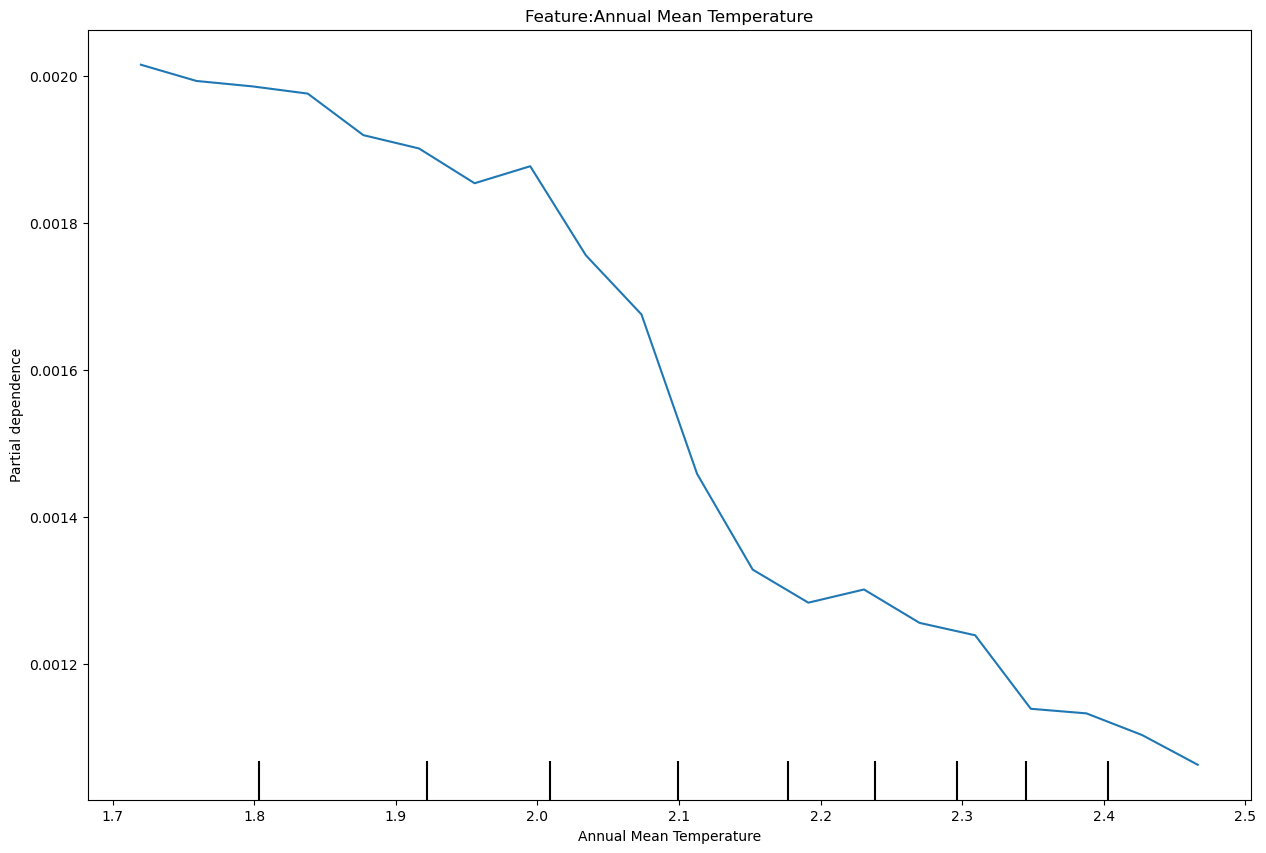

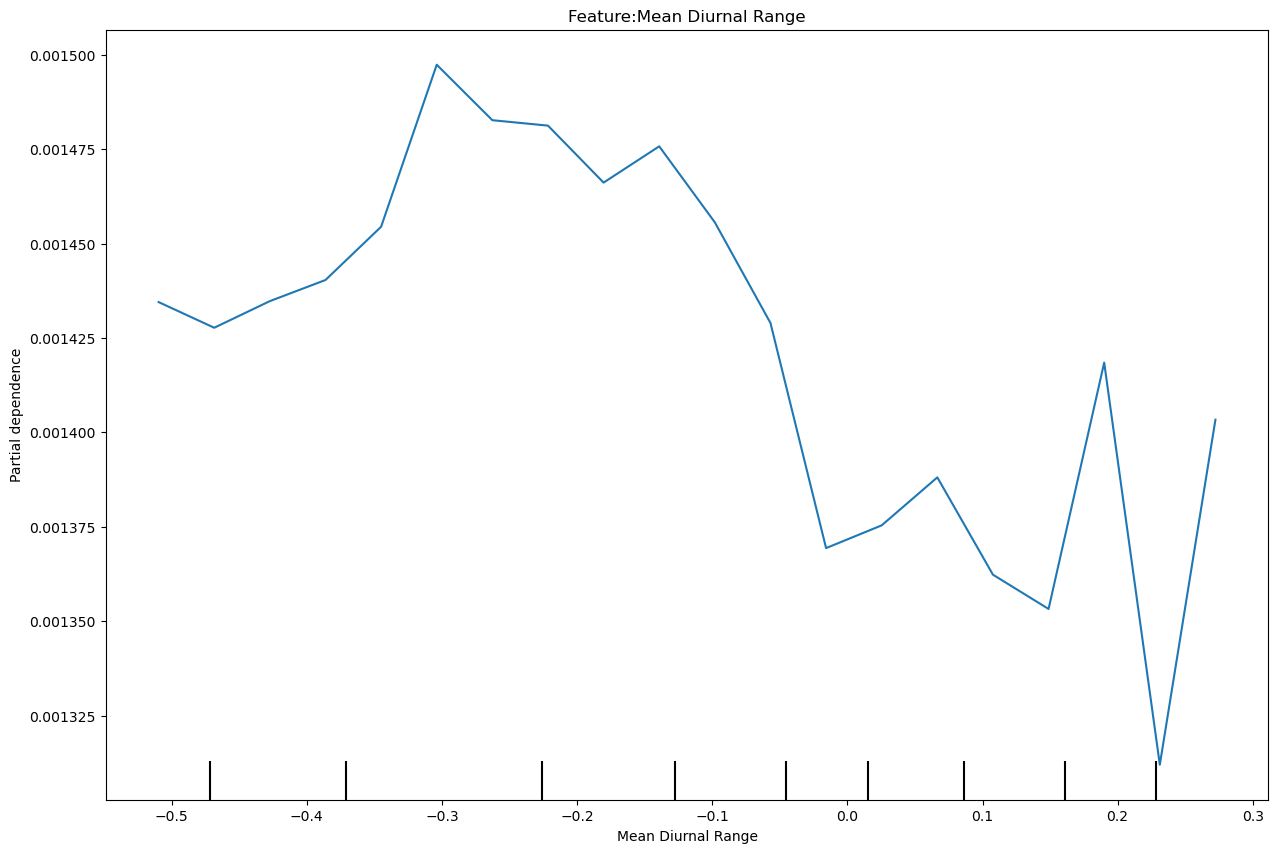

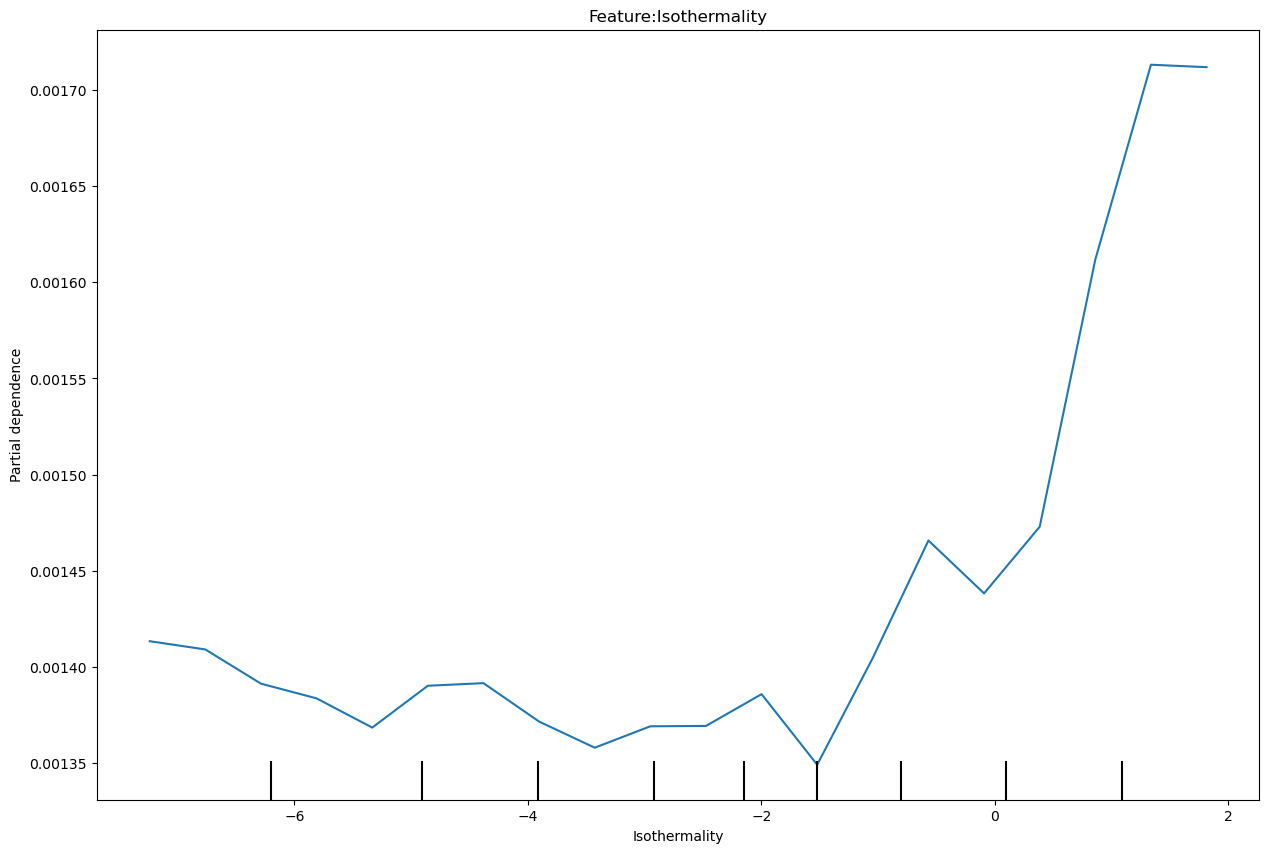

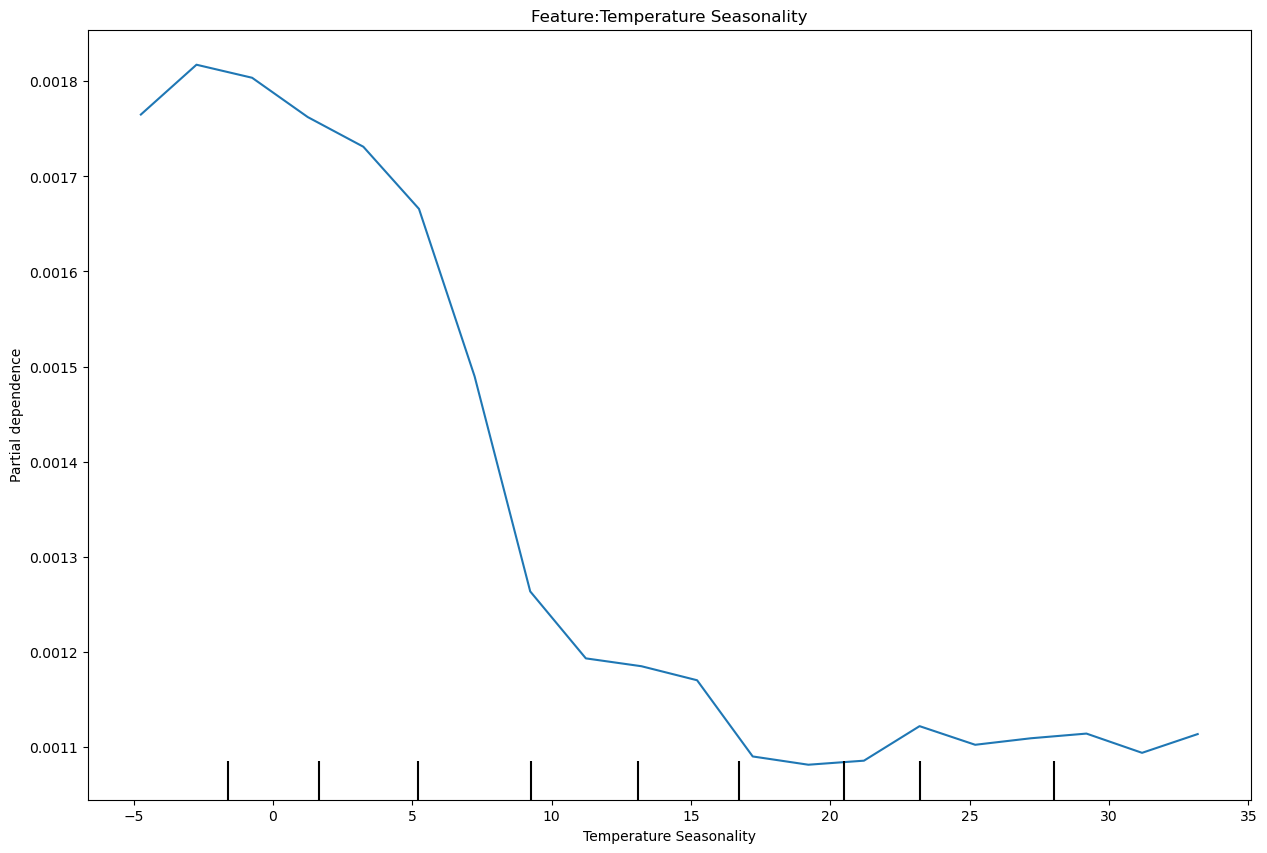

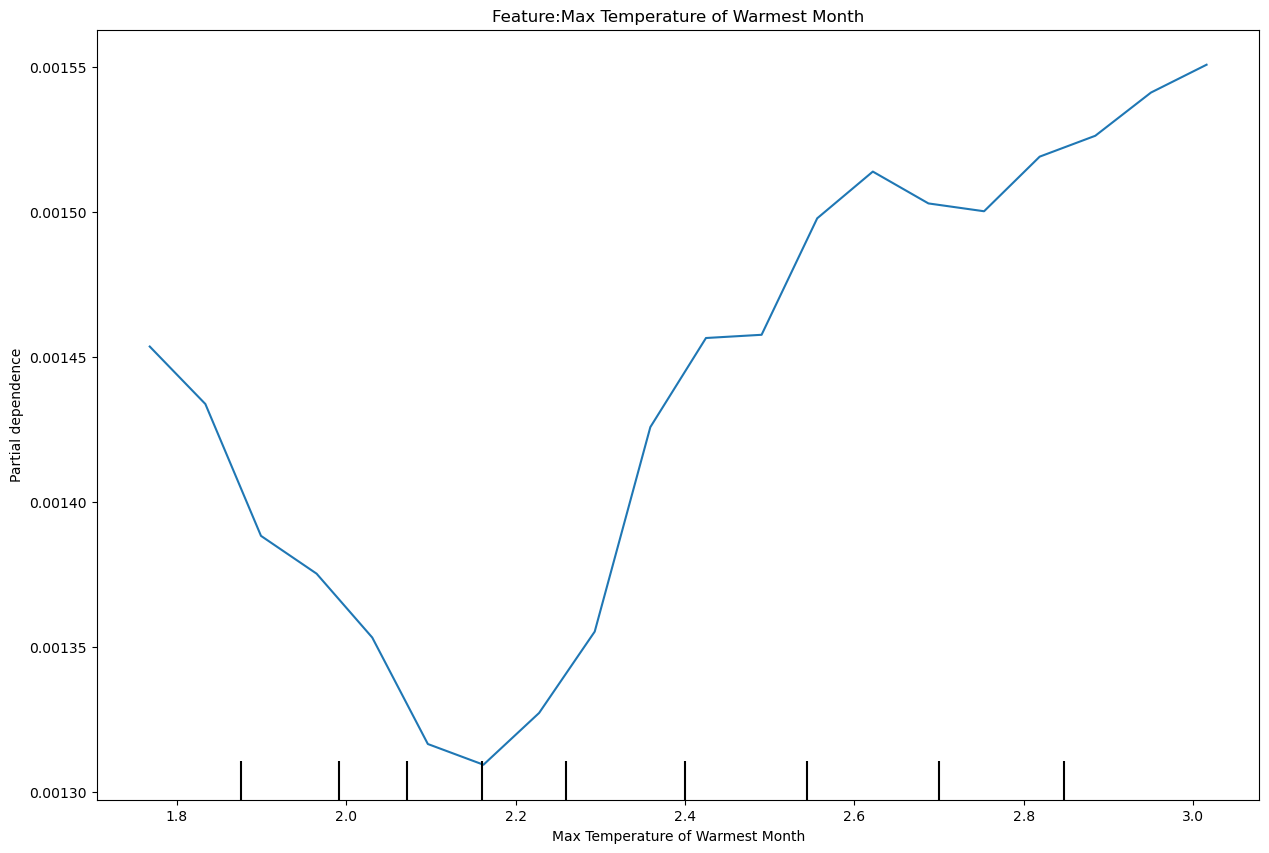

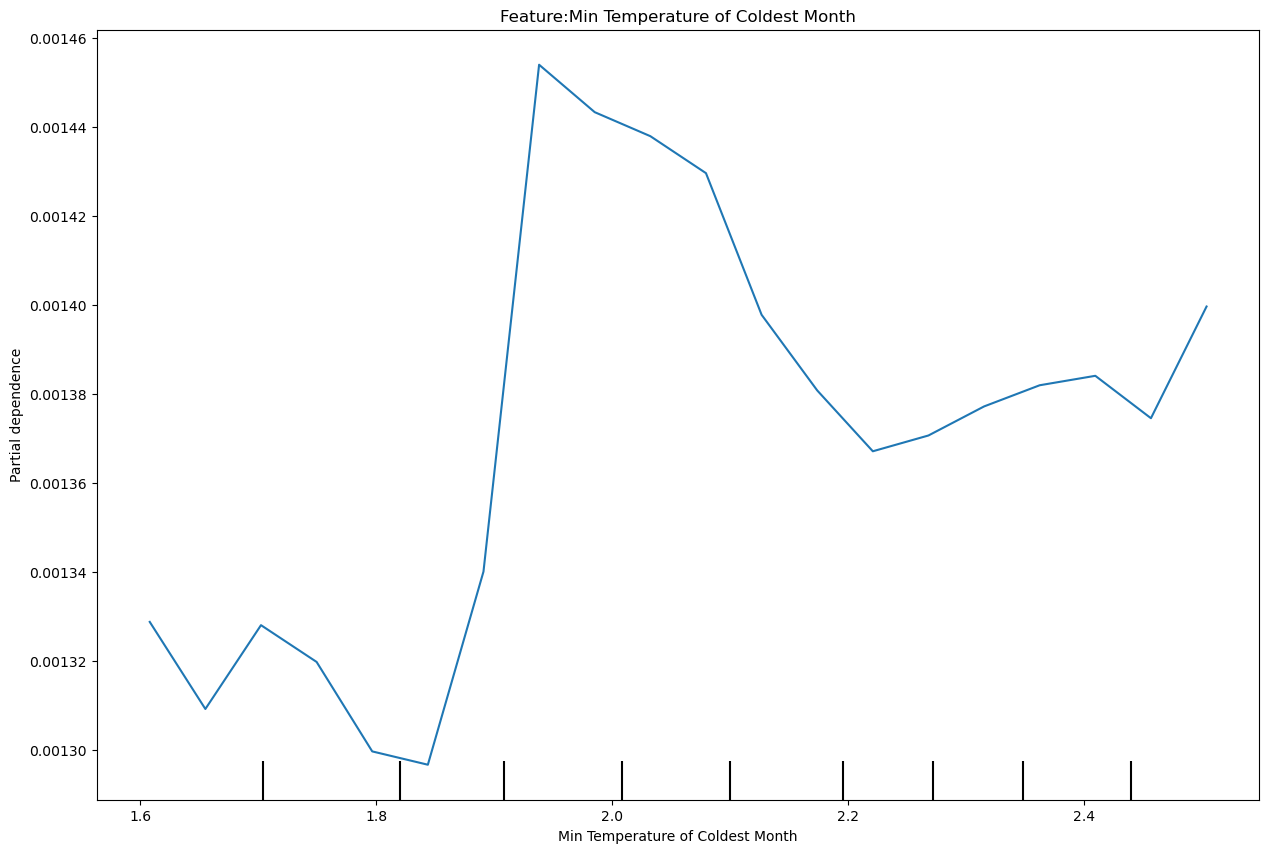

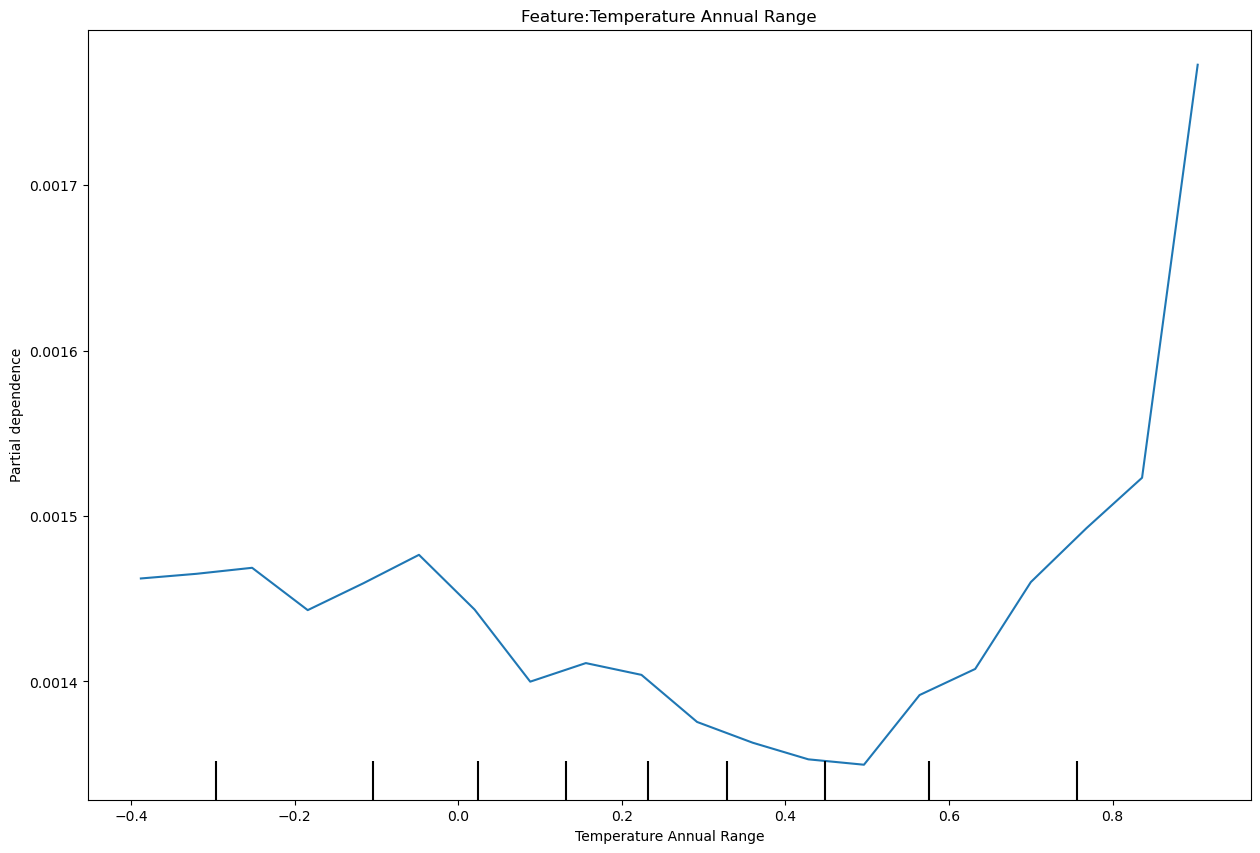

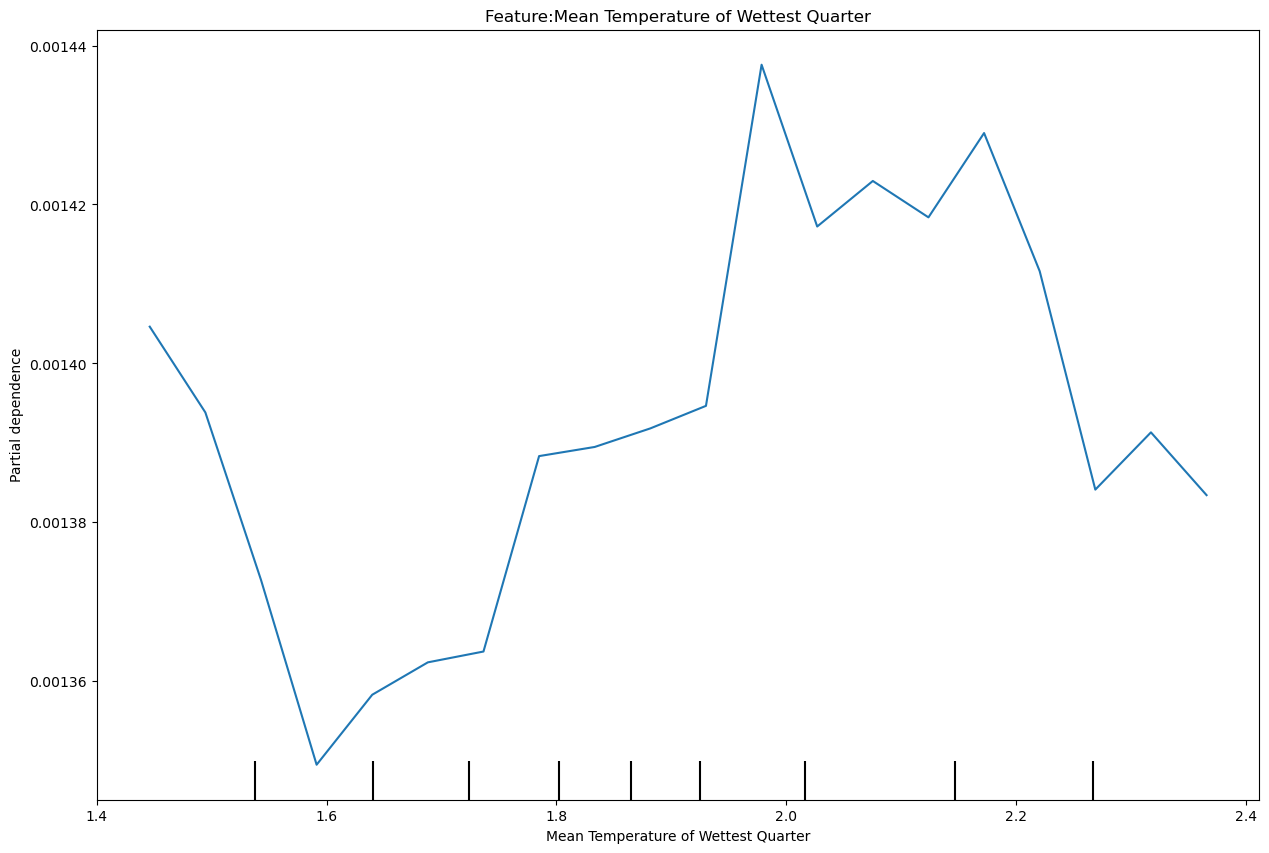

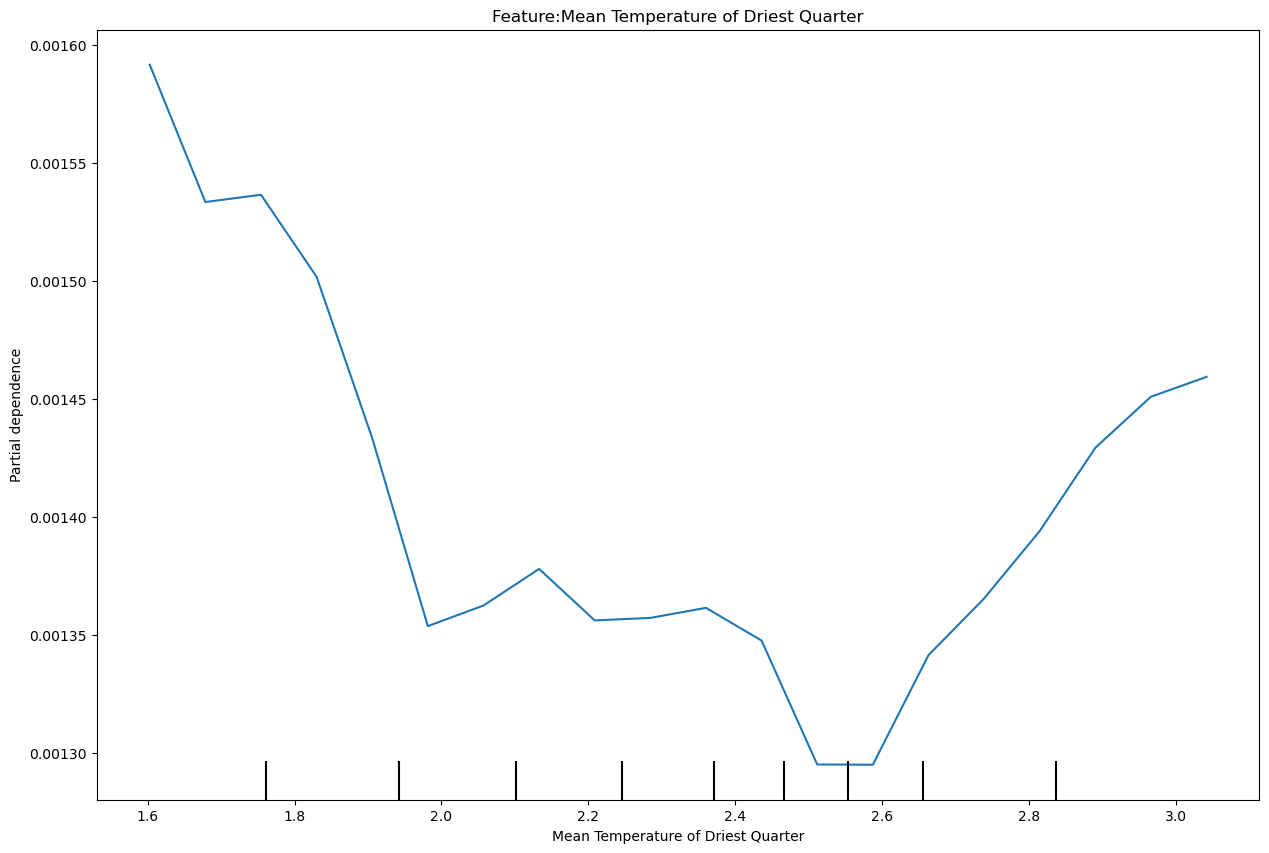

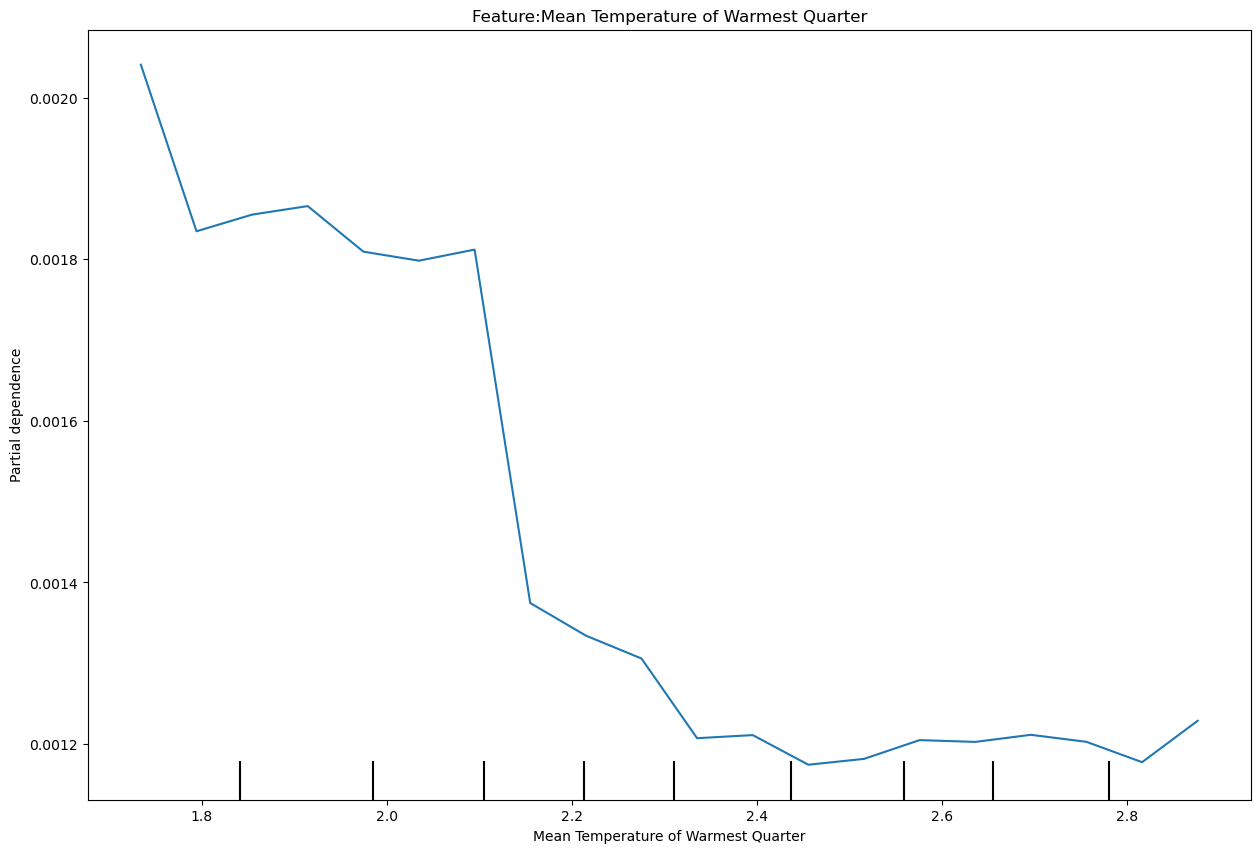

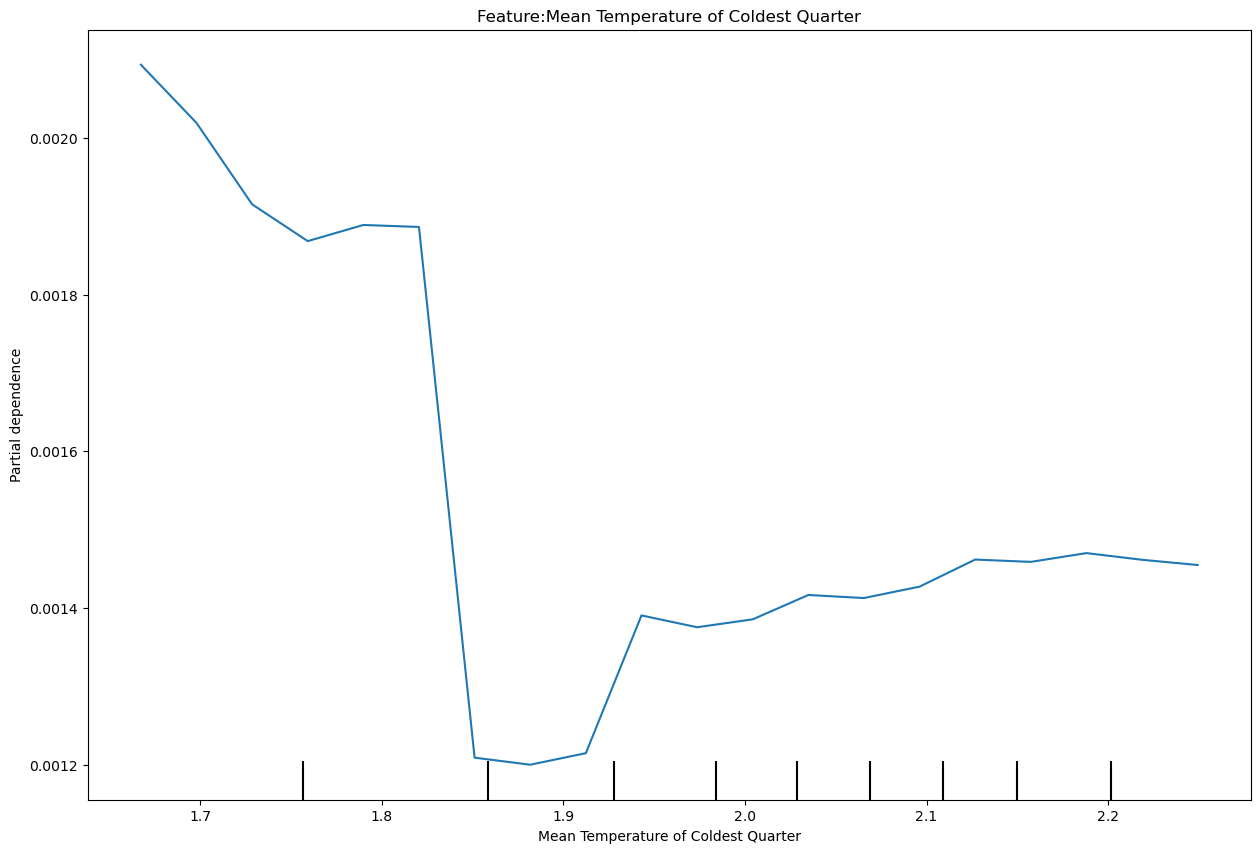

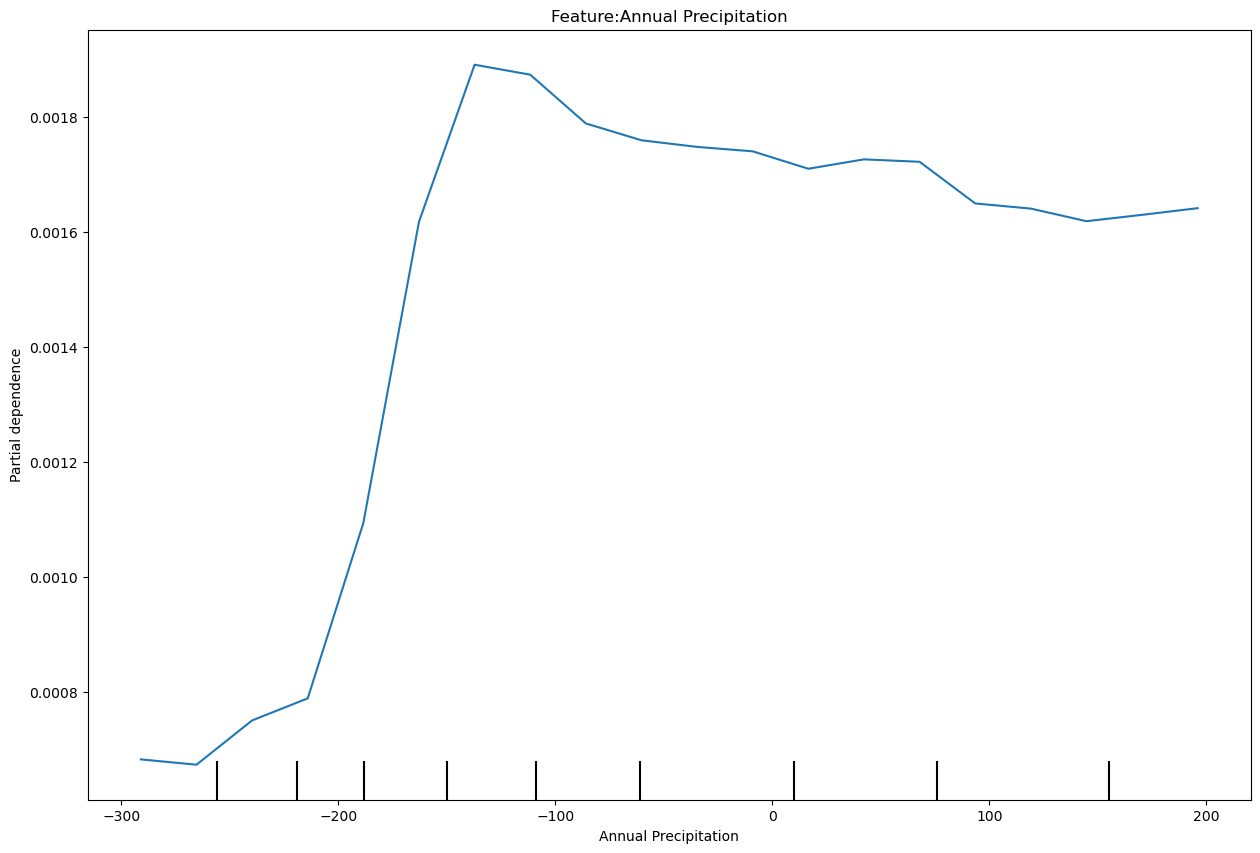

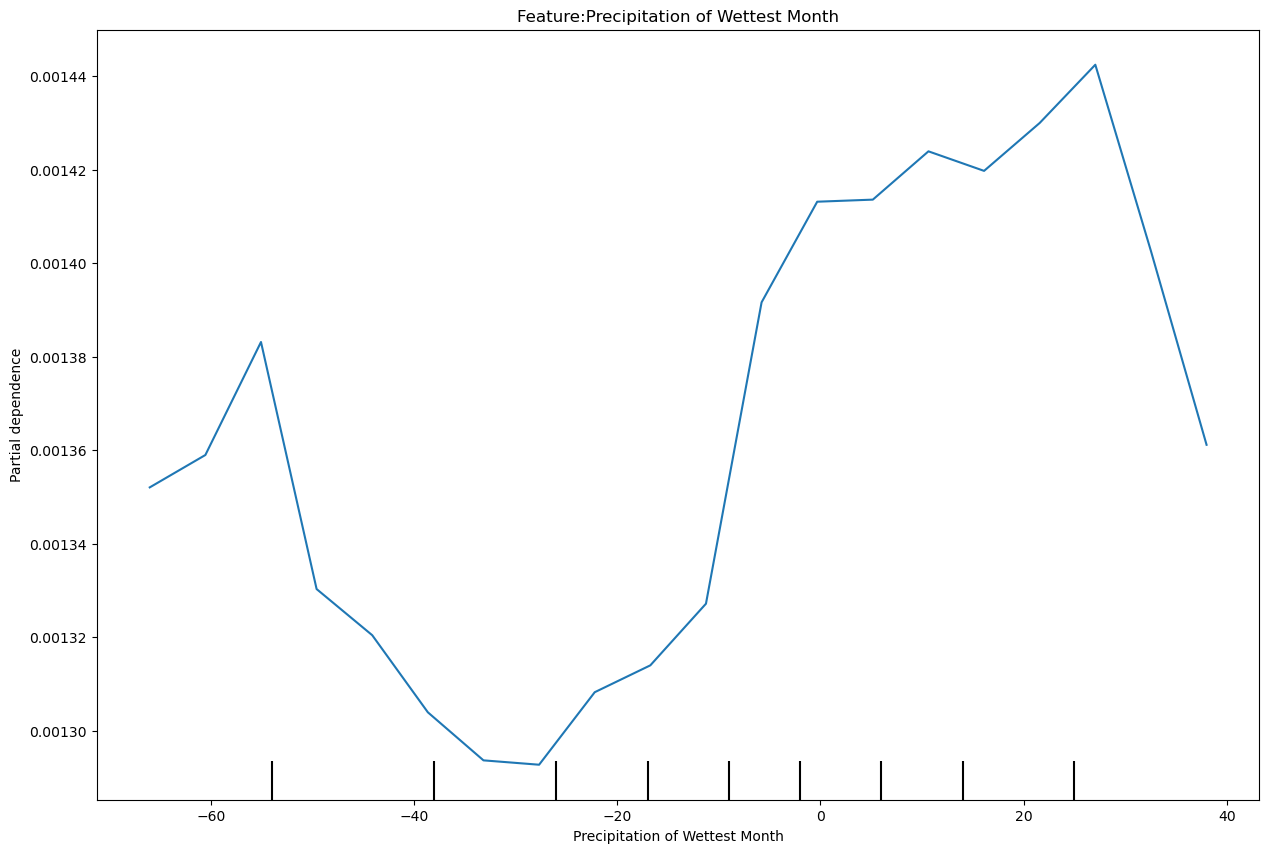

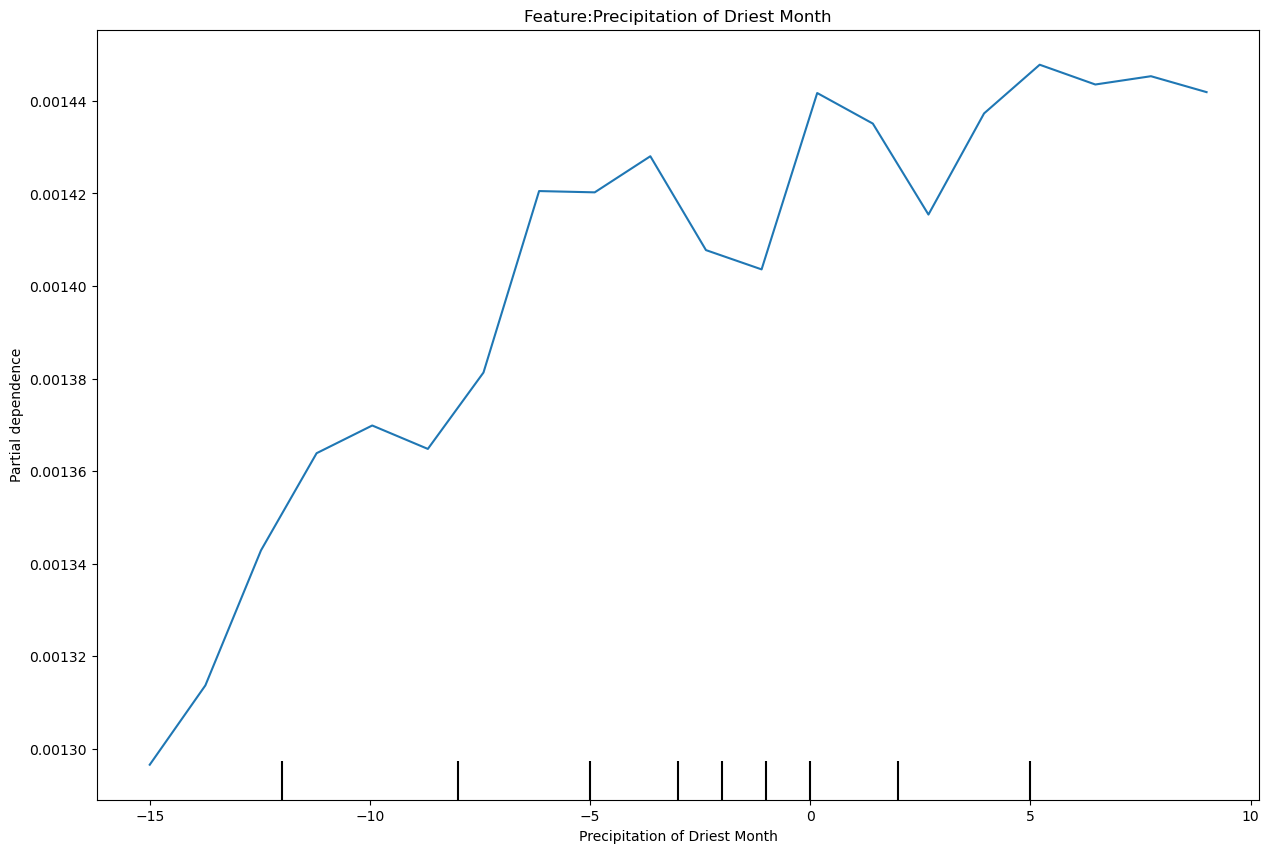

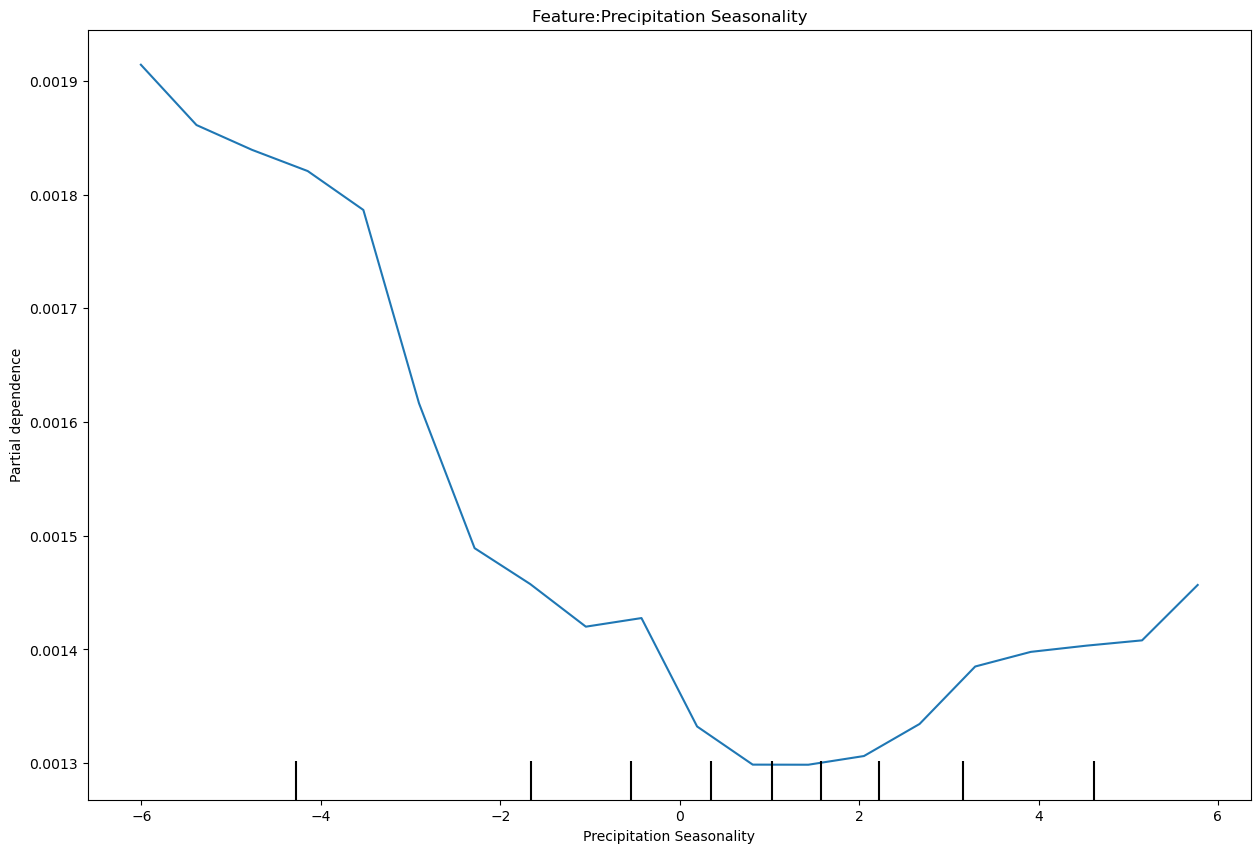

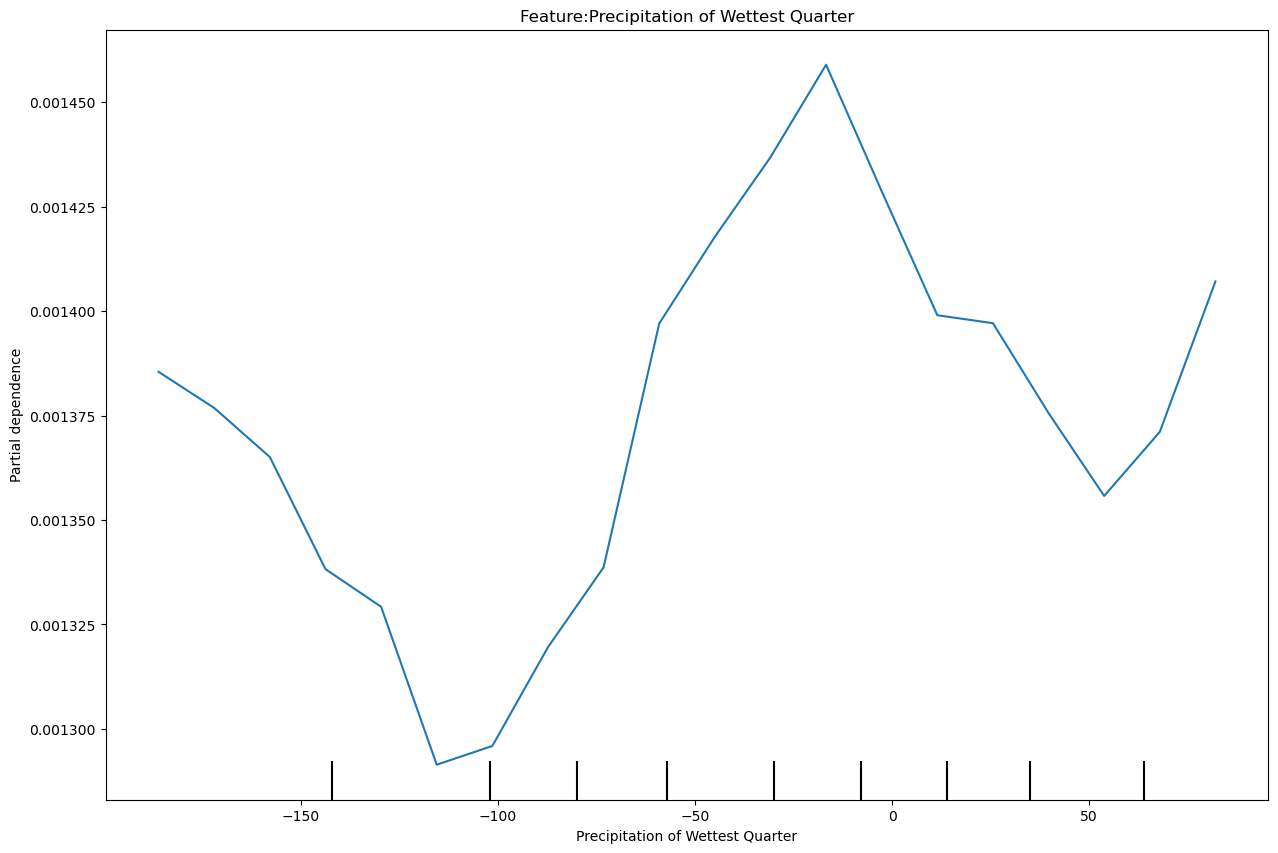

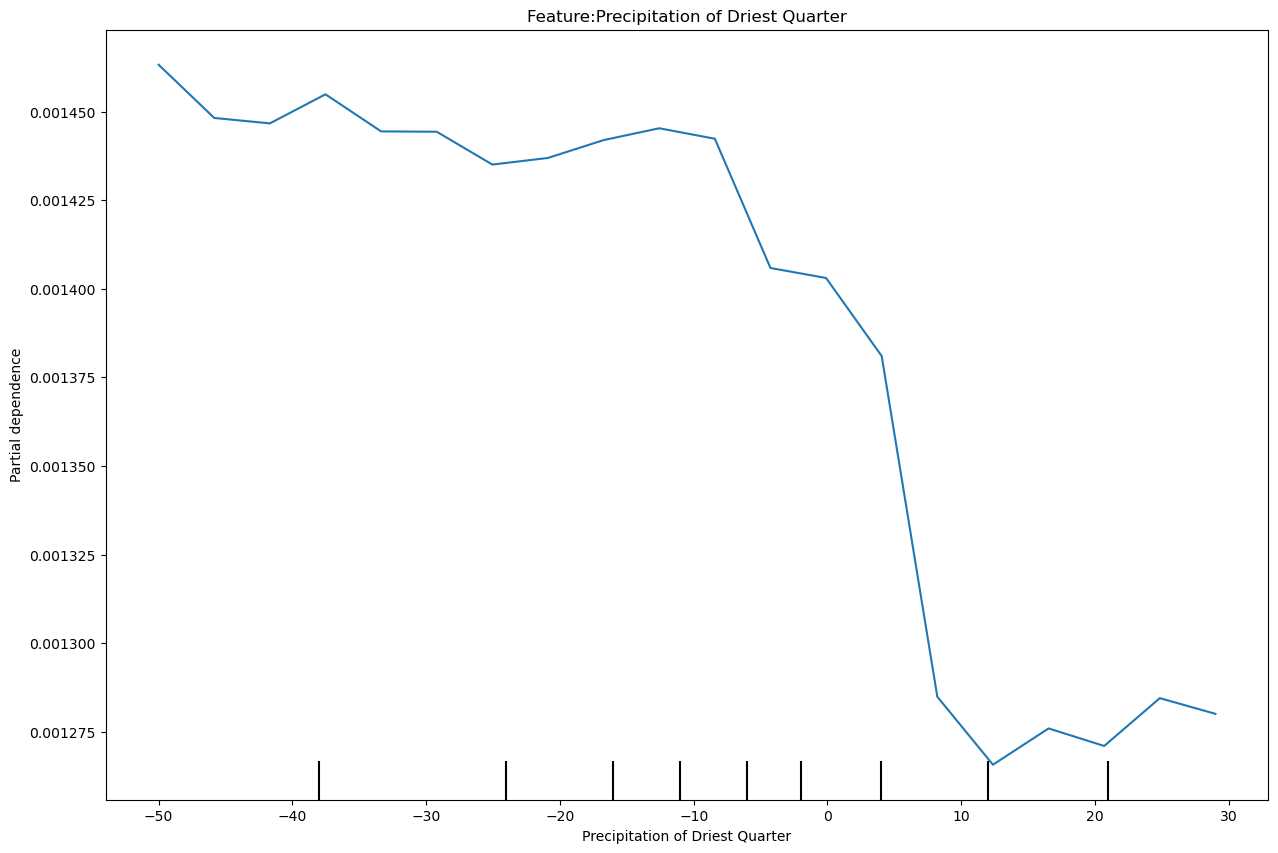

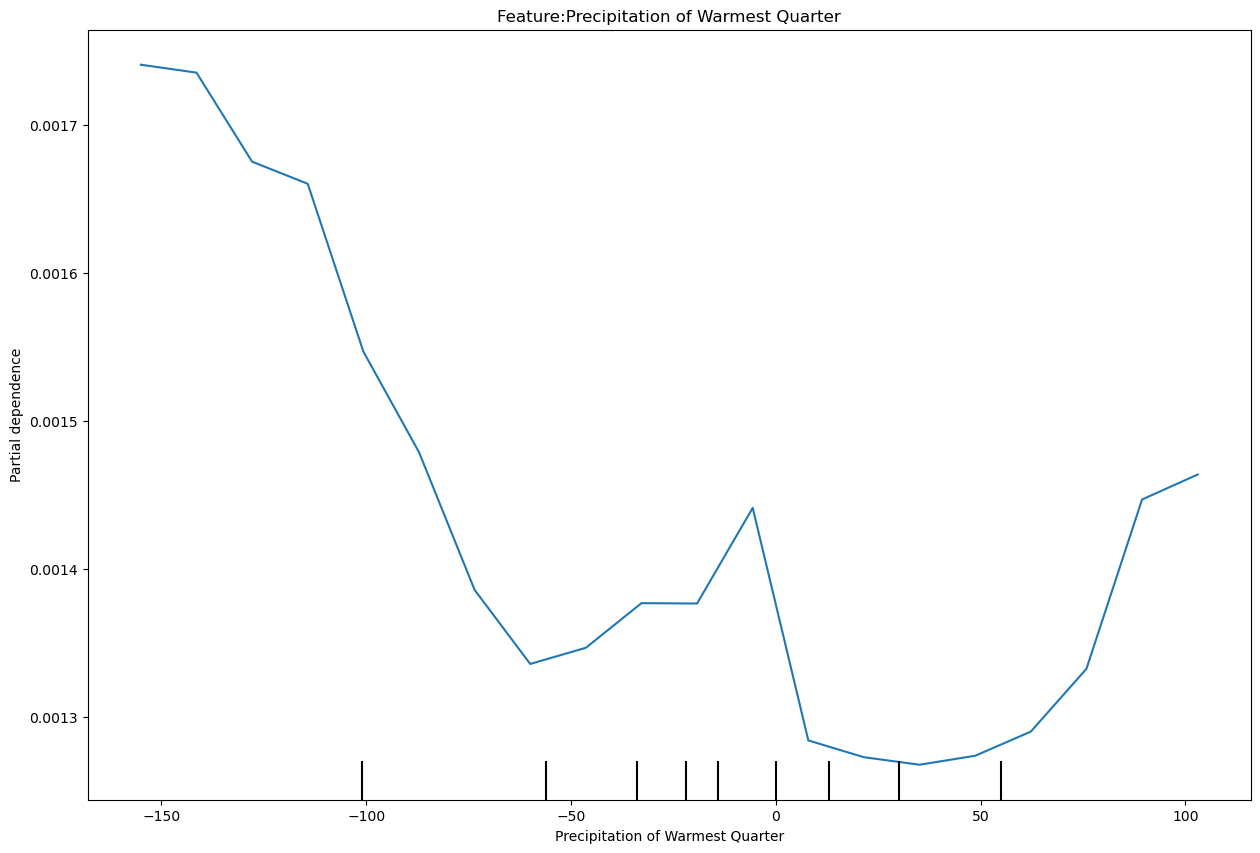

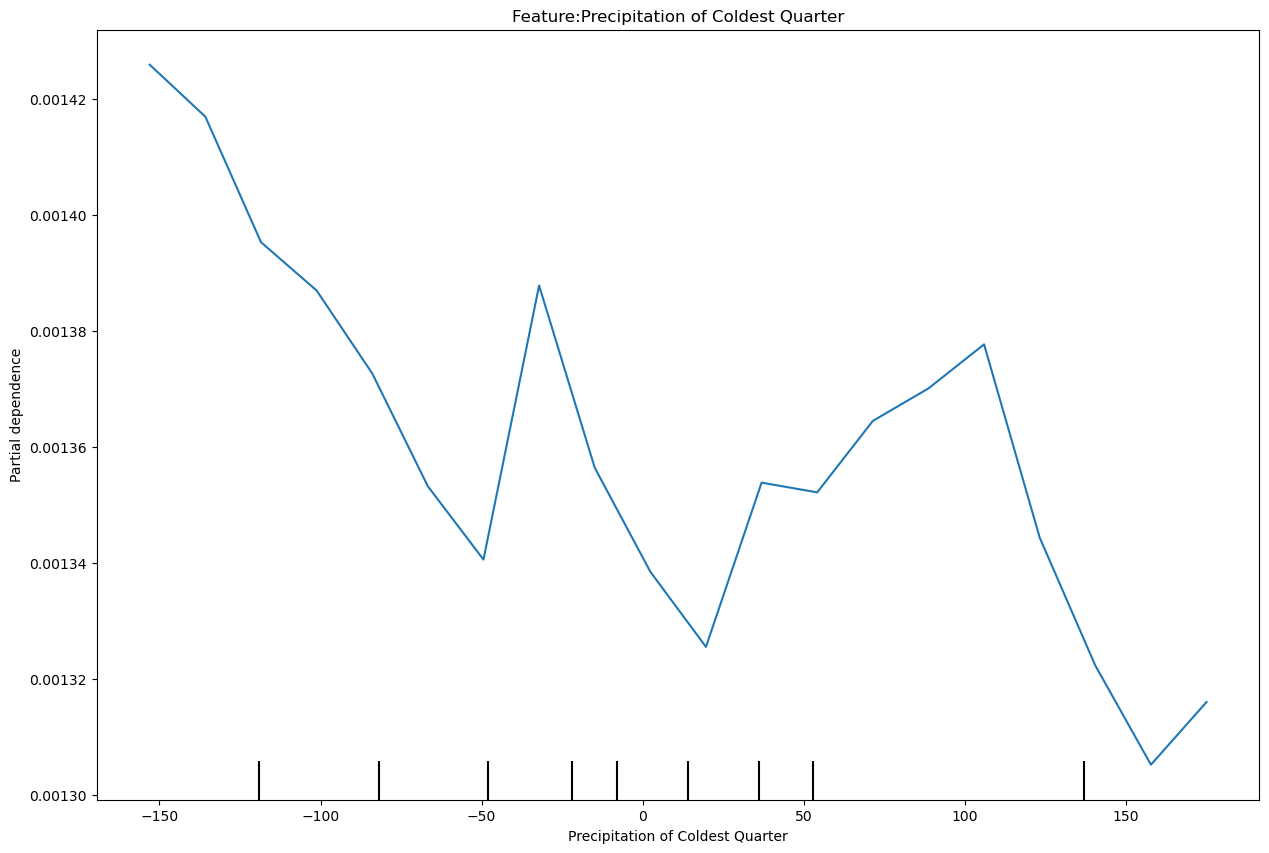

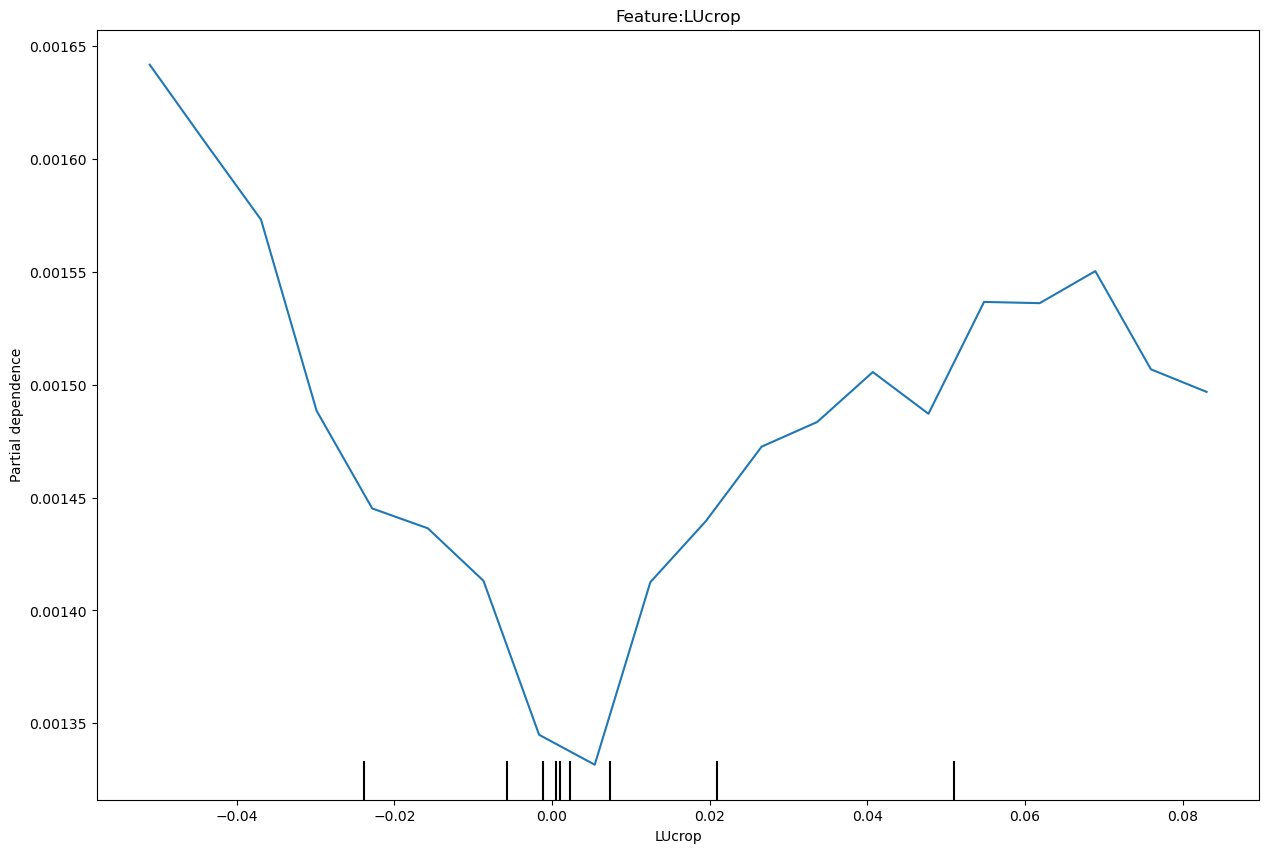

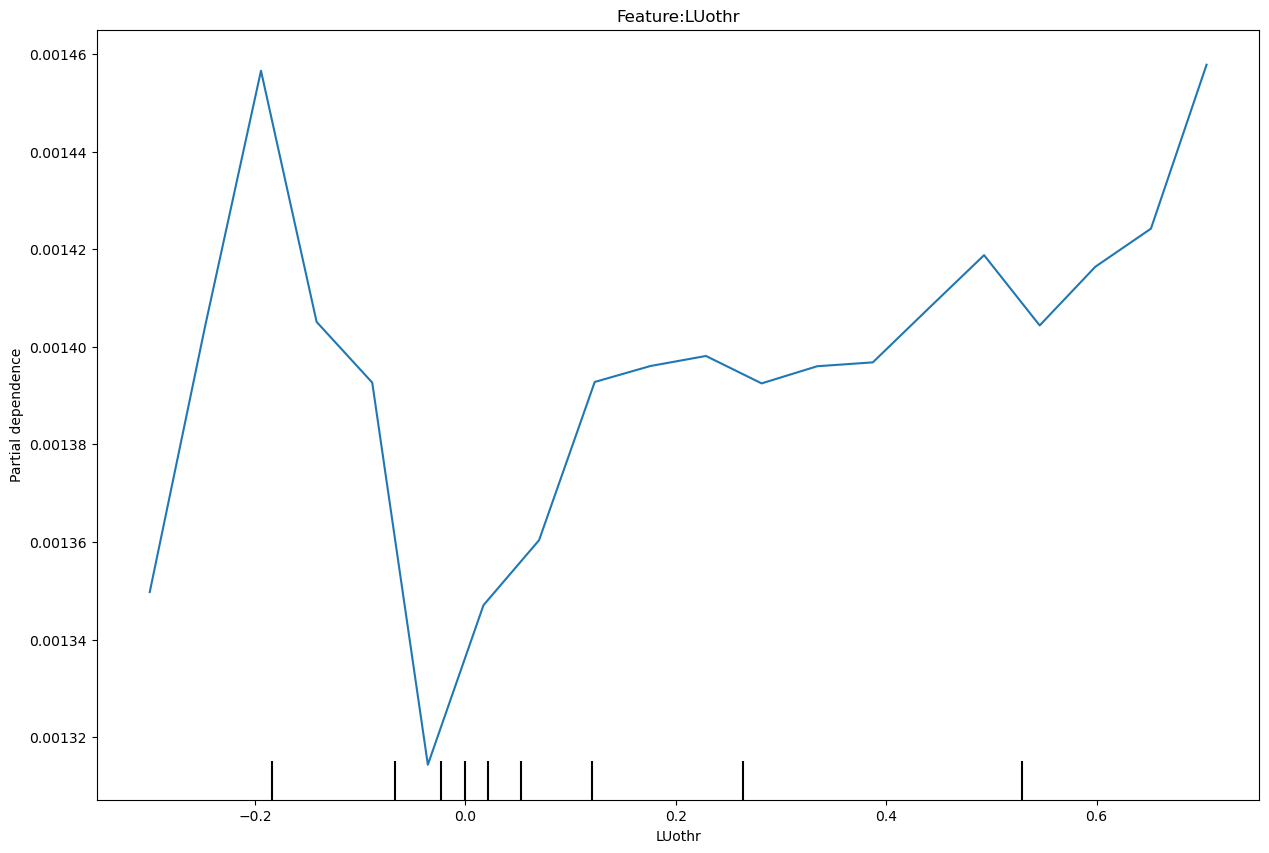

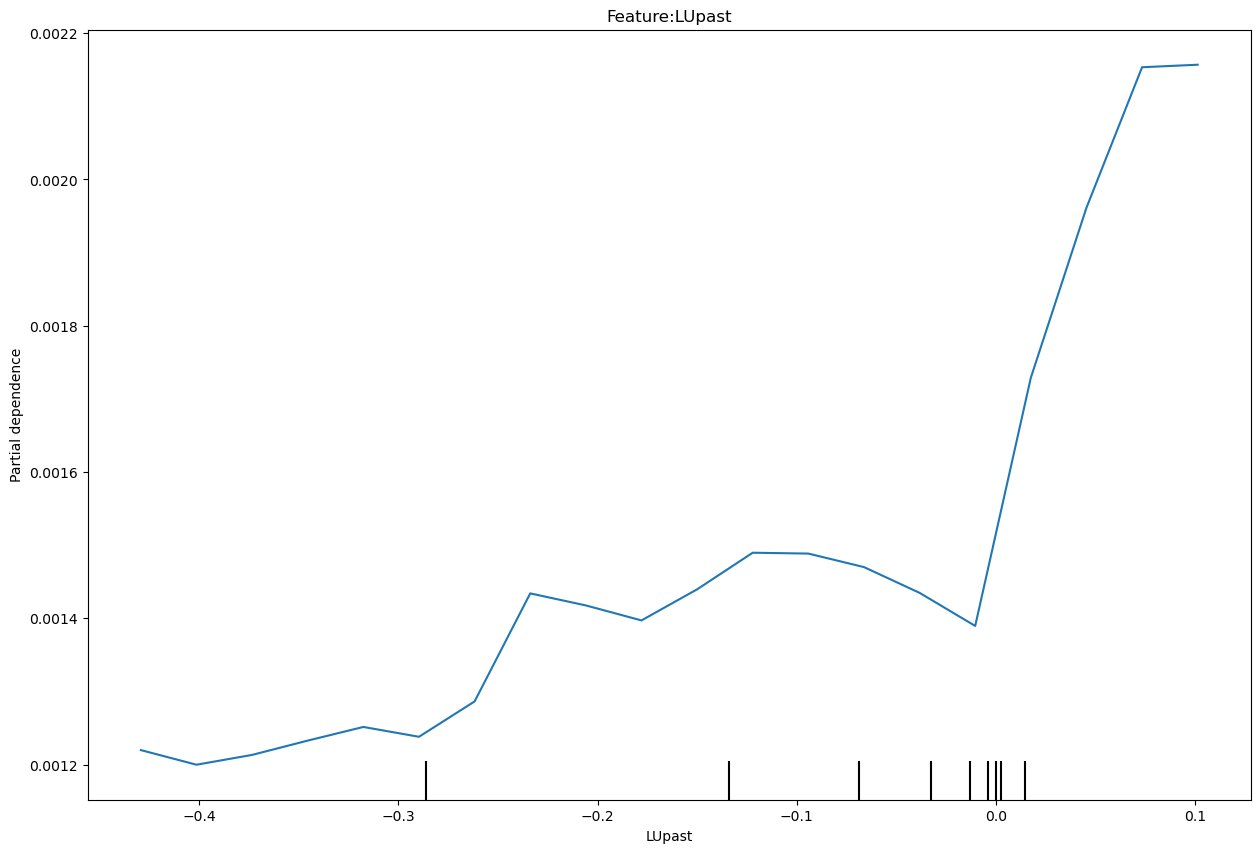

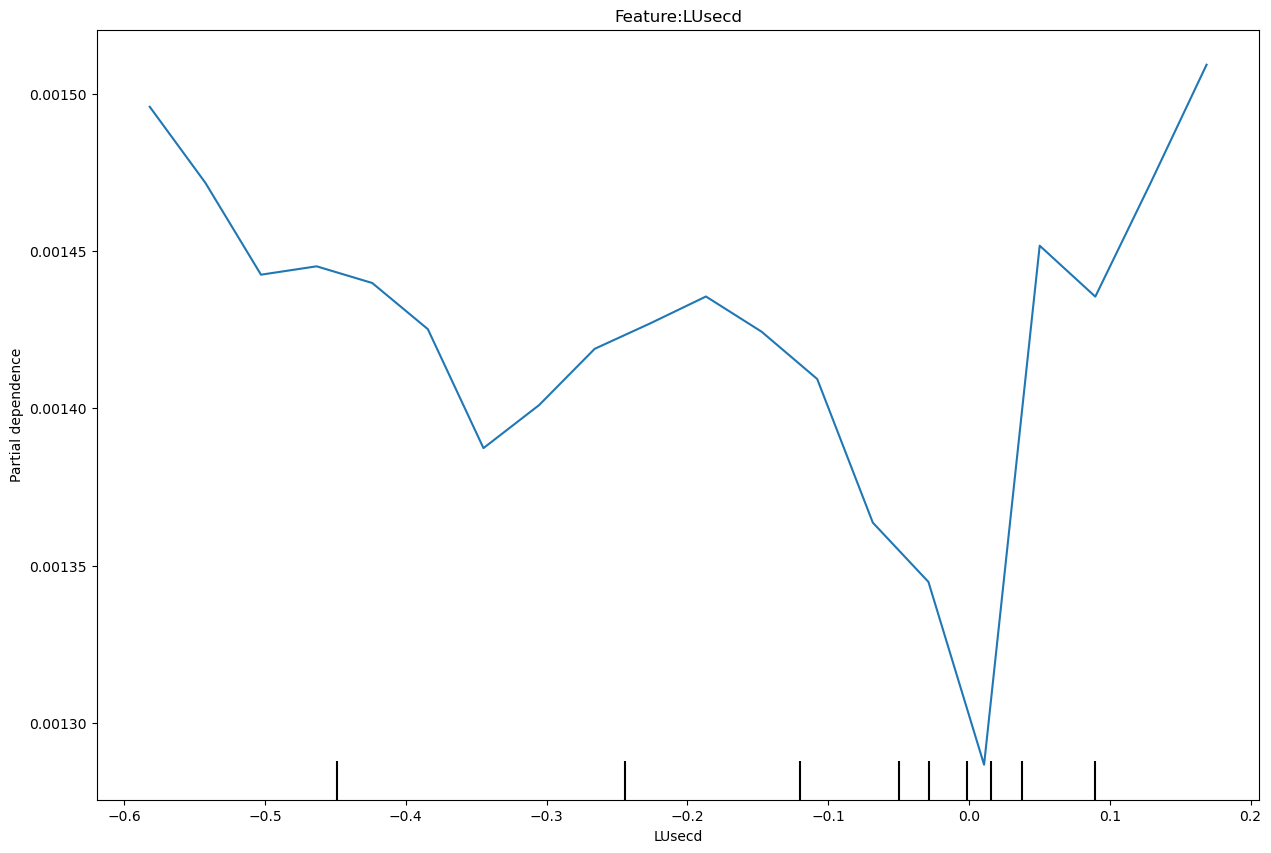

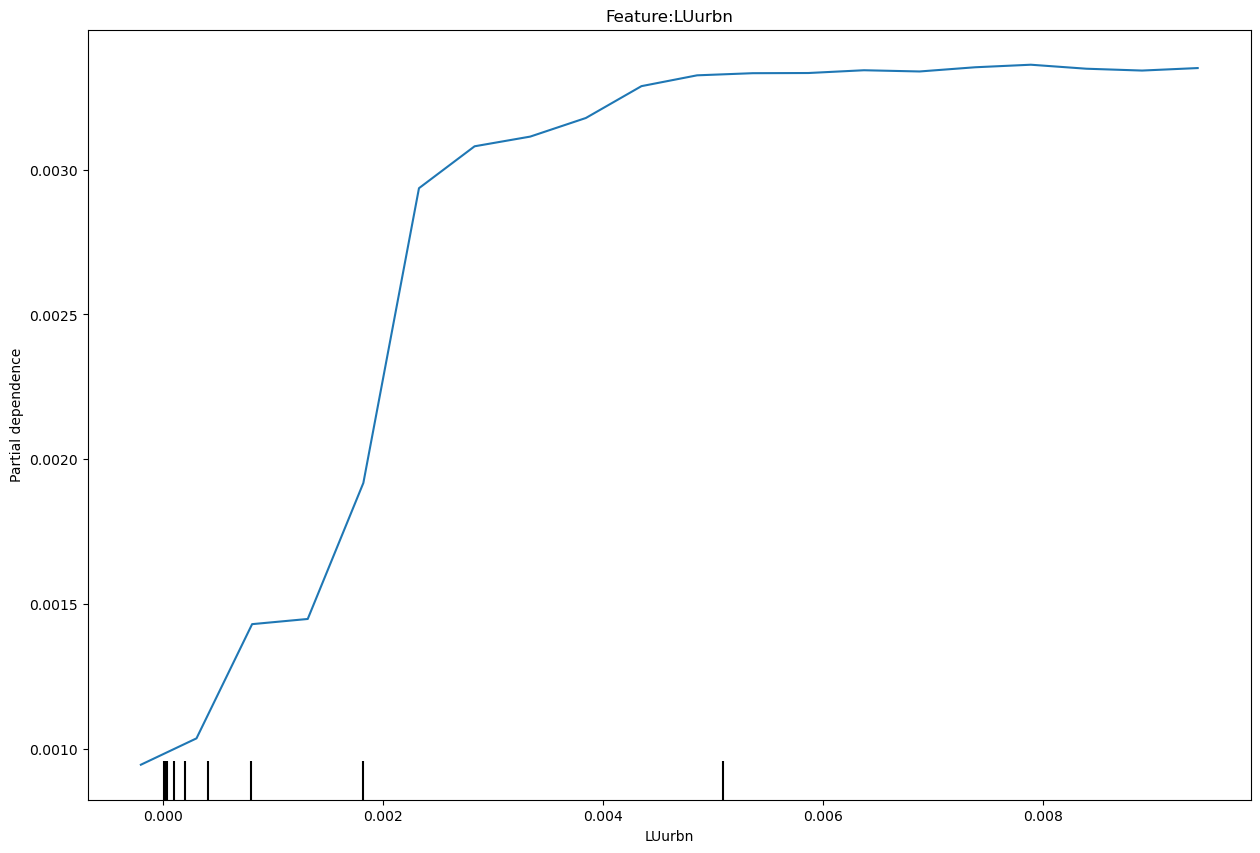

In [9]:
for i, feature in enumerate(list(range(X_train.shape[1]))):
    fig, ax = plt.subplots(figsize = (15,10))
    PartialDependenceDisplay.from_estimator(model_out, X_train, 
                                        features = [feature], 
                                        feature_names = feature_names,
                                            ax = ax,
                                        grid_resolution = 20)
    ax.set_title(f'Feature:{feature_names[feature]}')
    
    plt.show(fig)

In [10]:
# pdp_results = partial_dependence(model_out, X_train, features = indices)


# grid_values = pd.DataFrame()
# for i, feature in enumerate(indices):
#     feature_grid = pd.DataFrame({
#         f"Feature_{feature}_grid": pdp_results['grid_values'][i],  # Grid values
#         f"Feature_{feature}_pdp": pdp_results['average'][i]   # Partial dependence values
#     })
#     grid_values = pd.concat([grid_values, feature_grid], axis=1)

# grid_values.to_csv("./Data/Input/Processed/Projected/guan/delta_SSP2/delta_ssp2_FOI_ML_sig.csv", index = False)

In [11]:
X_train = np.array(delta_ssp5_sample.loc[:, delta_ssp5_sample.columns != 'foi'])
Y_train = np.array(delta_ssp5_sample.foi)
print(X_train.shape, Y_train.shape)

(227006, 24) (227006,)


In [12]:
model_out2 = regressor.fit(X_train, Y_train)
feat_imp2 = regressor.fit(X_train, Y_train).feature_importances_
indices = np.argsort(feat_imp2)[-5:]

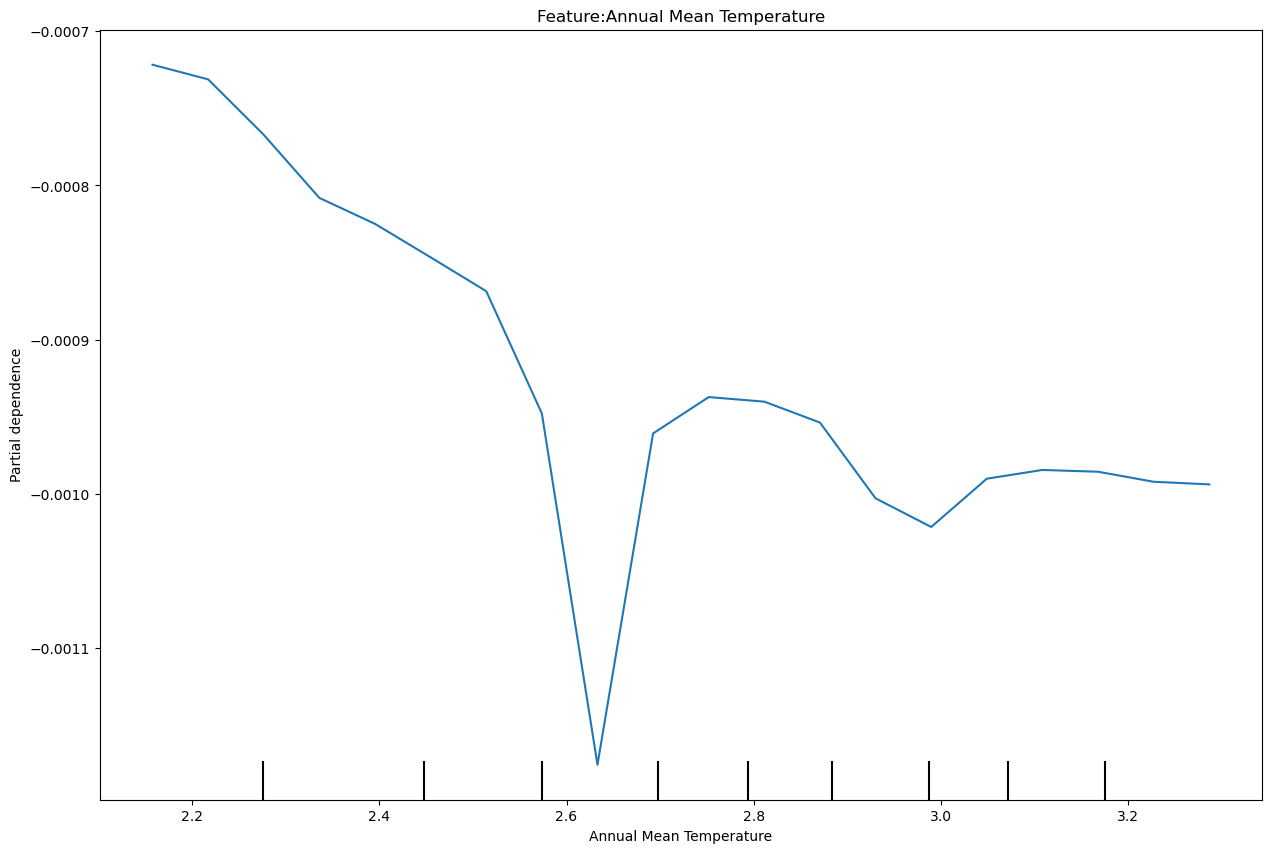

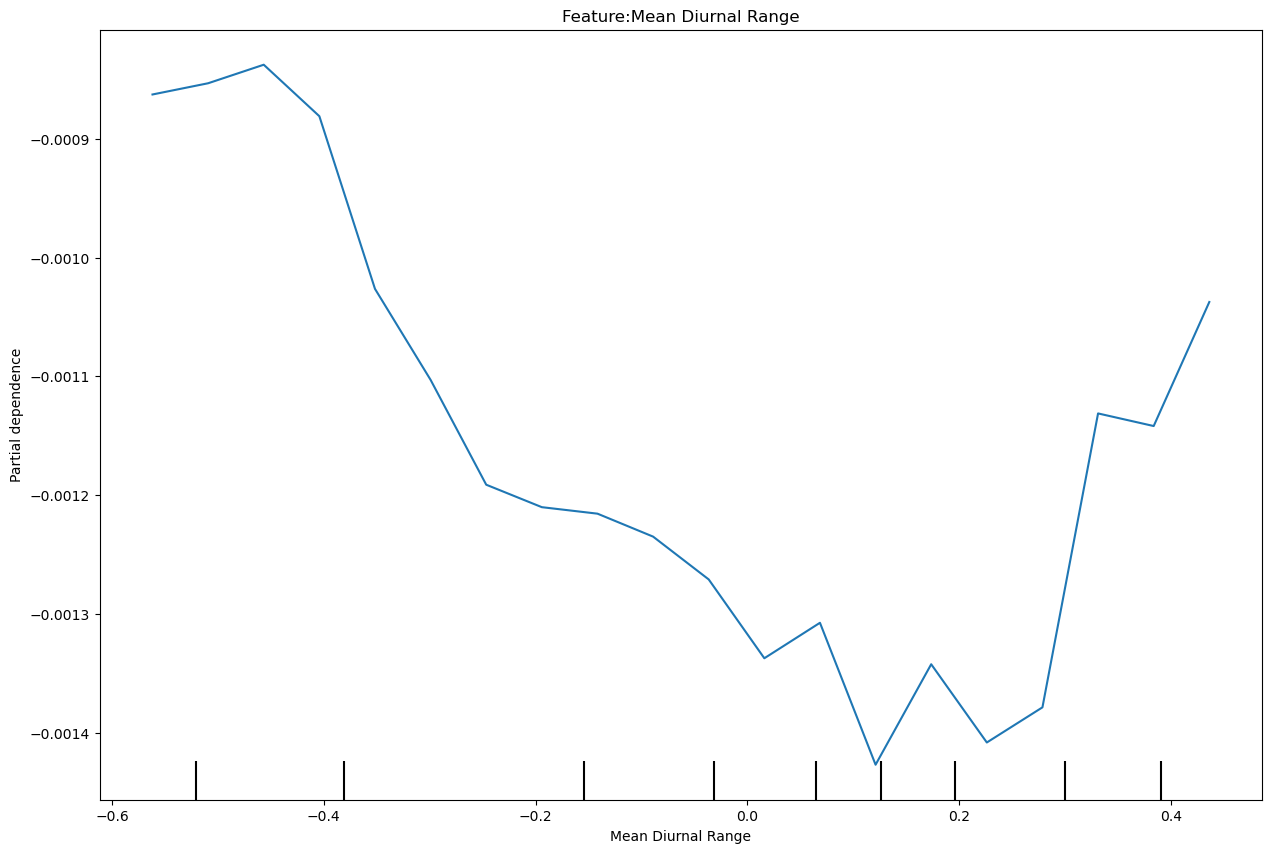

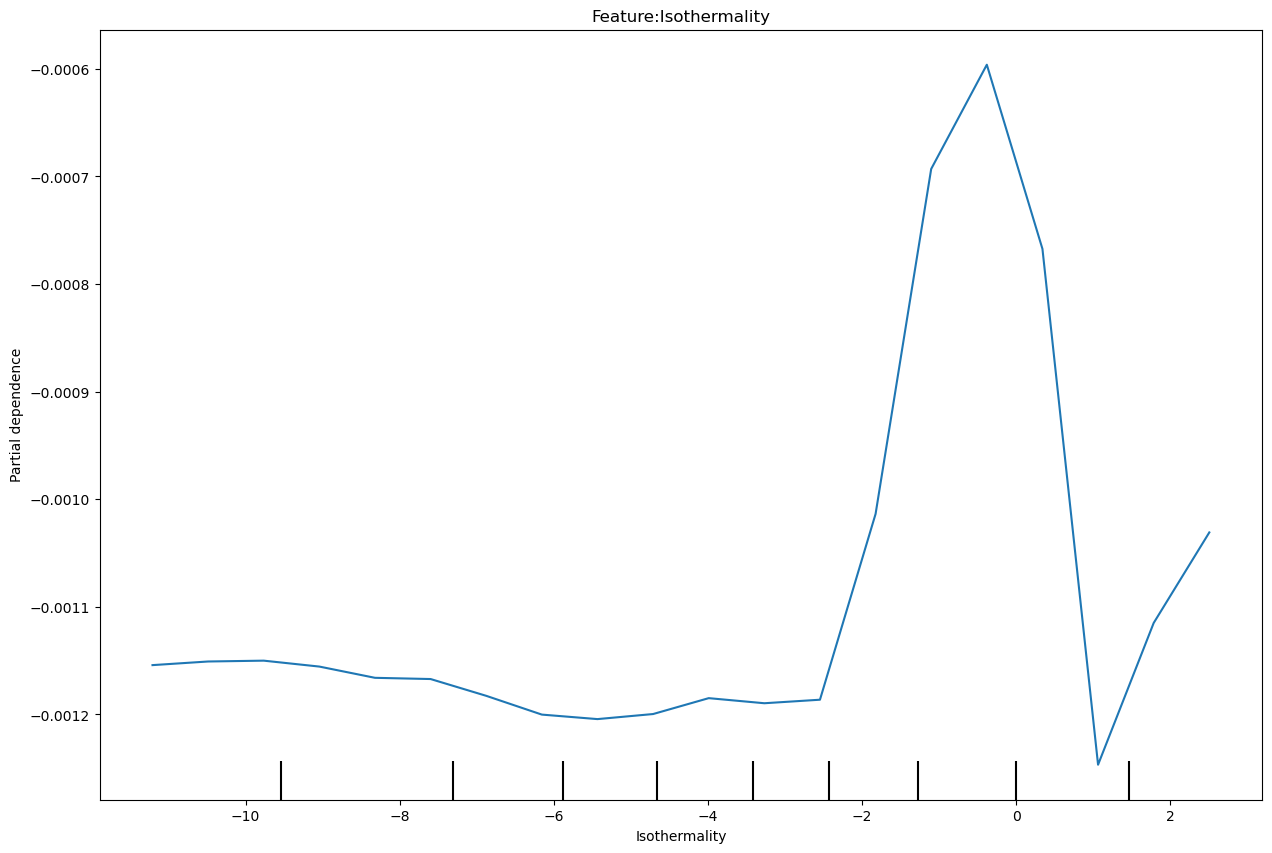

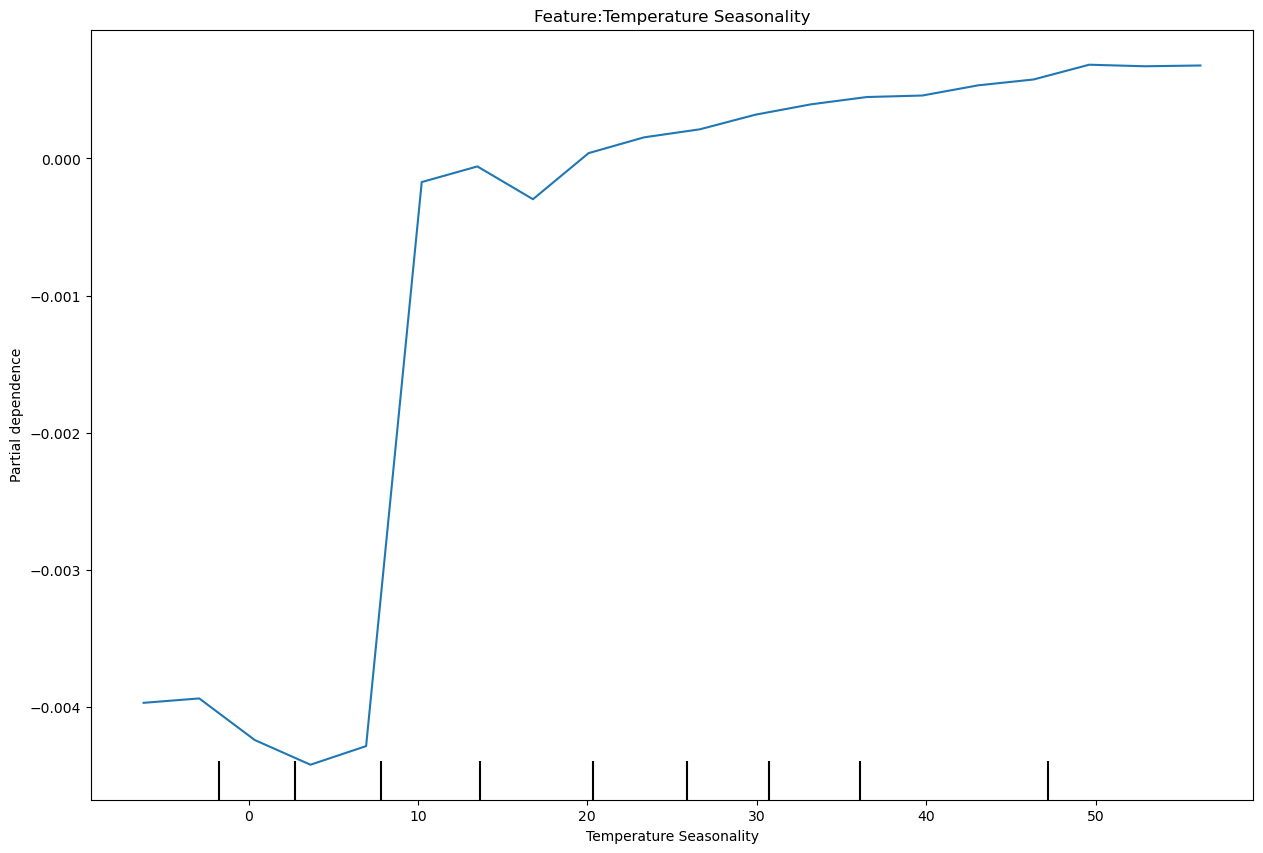

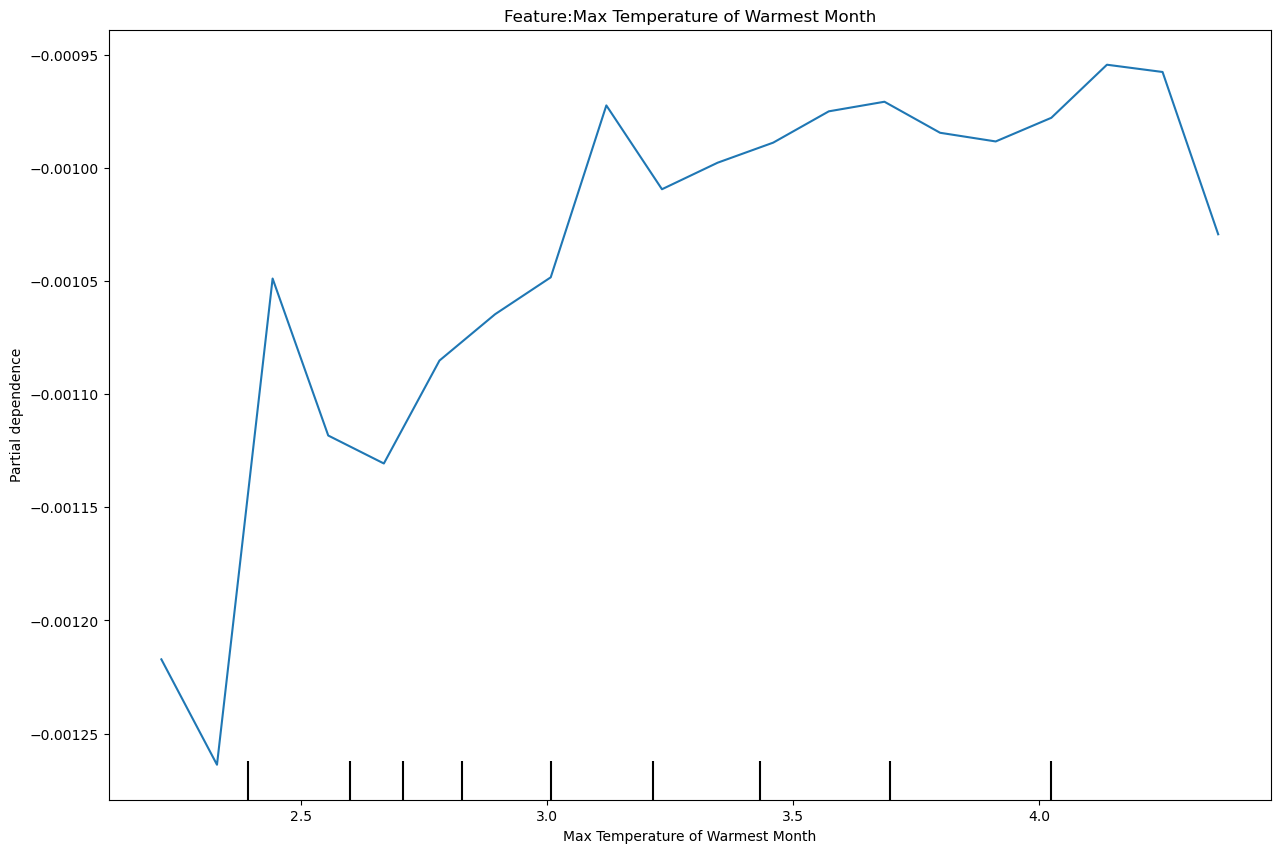

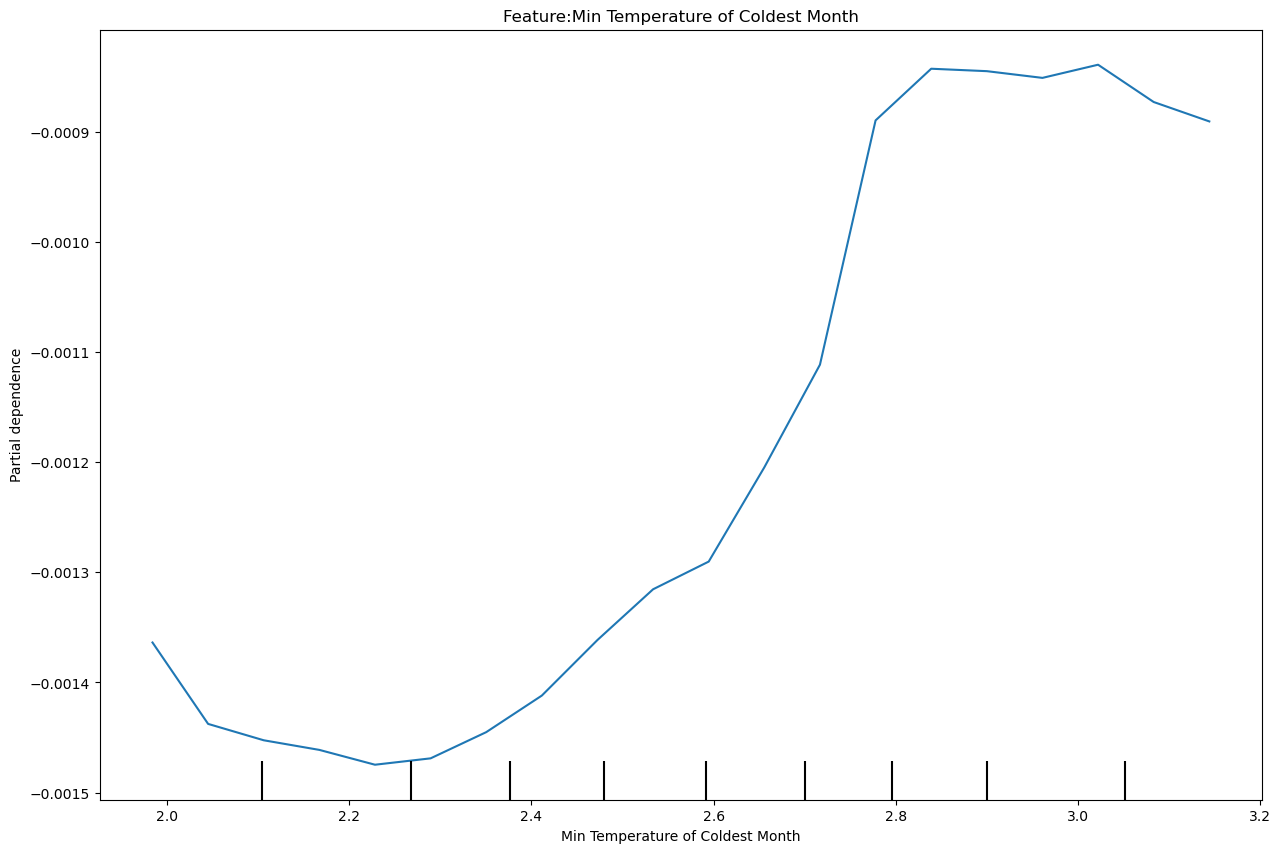

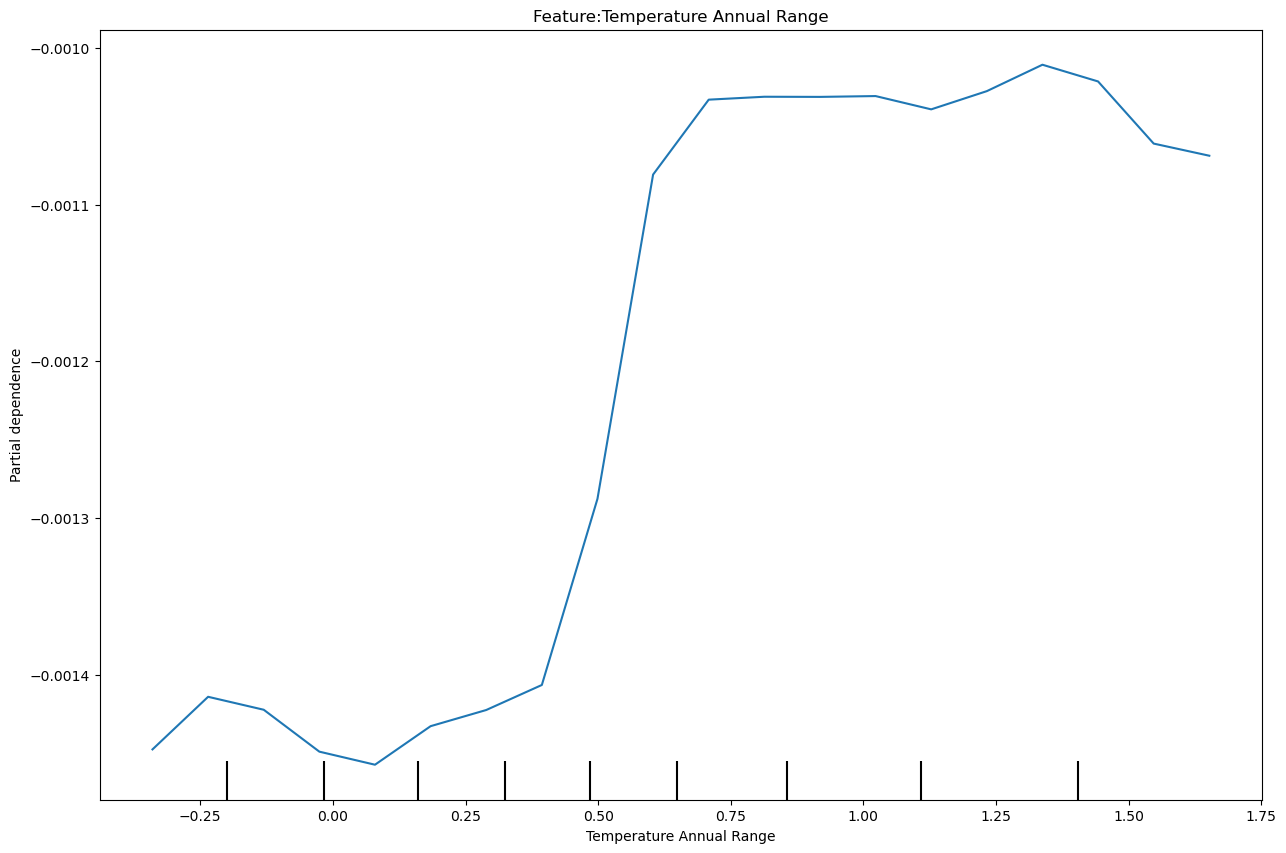

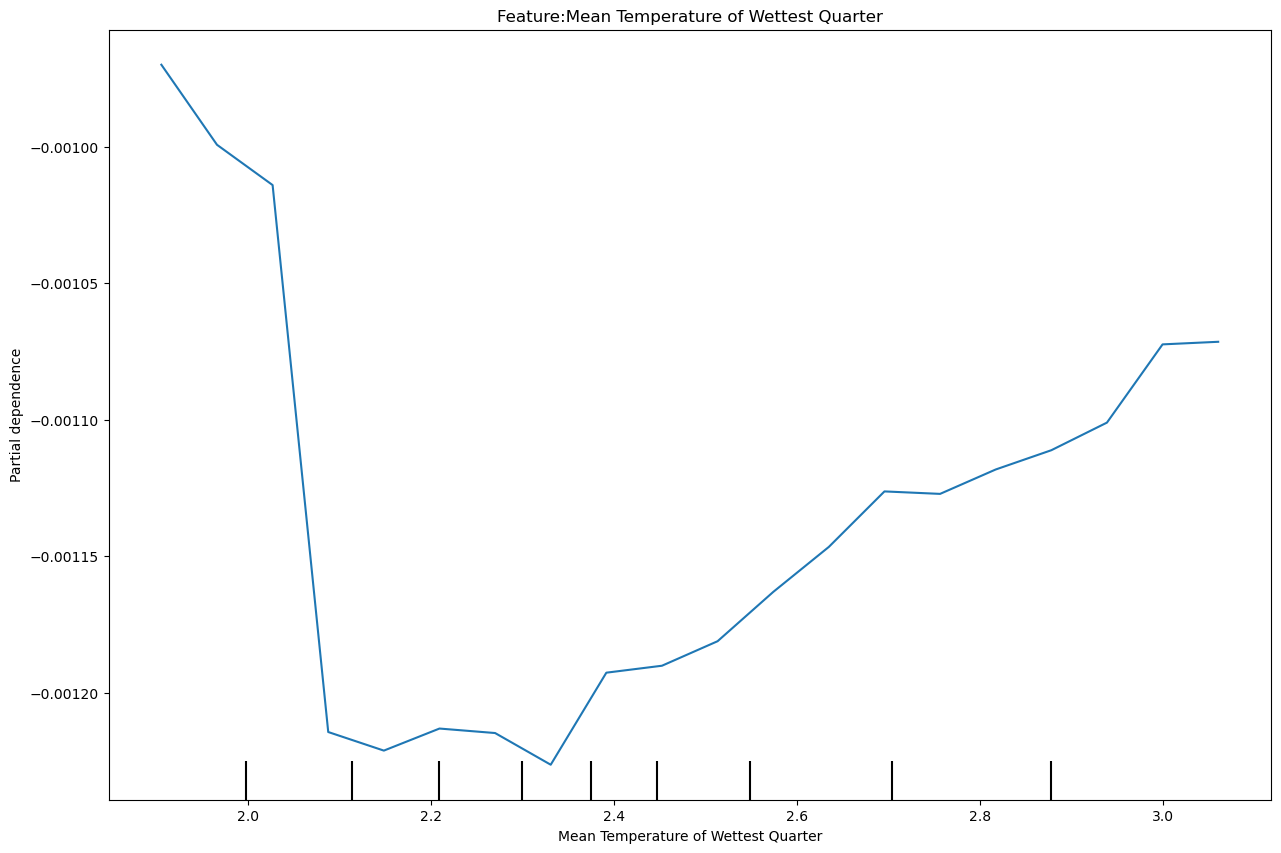

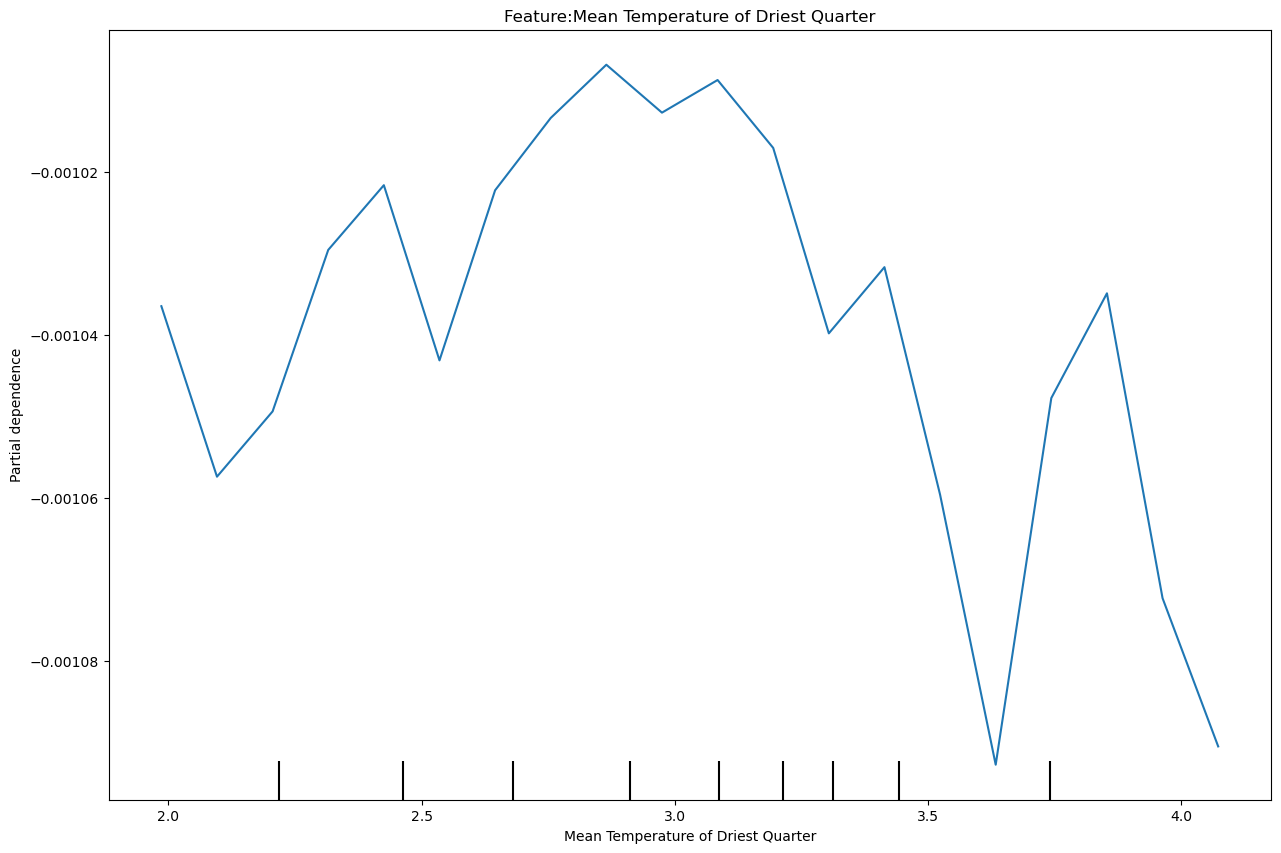

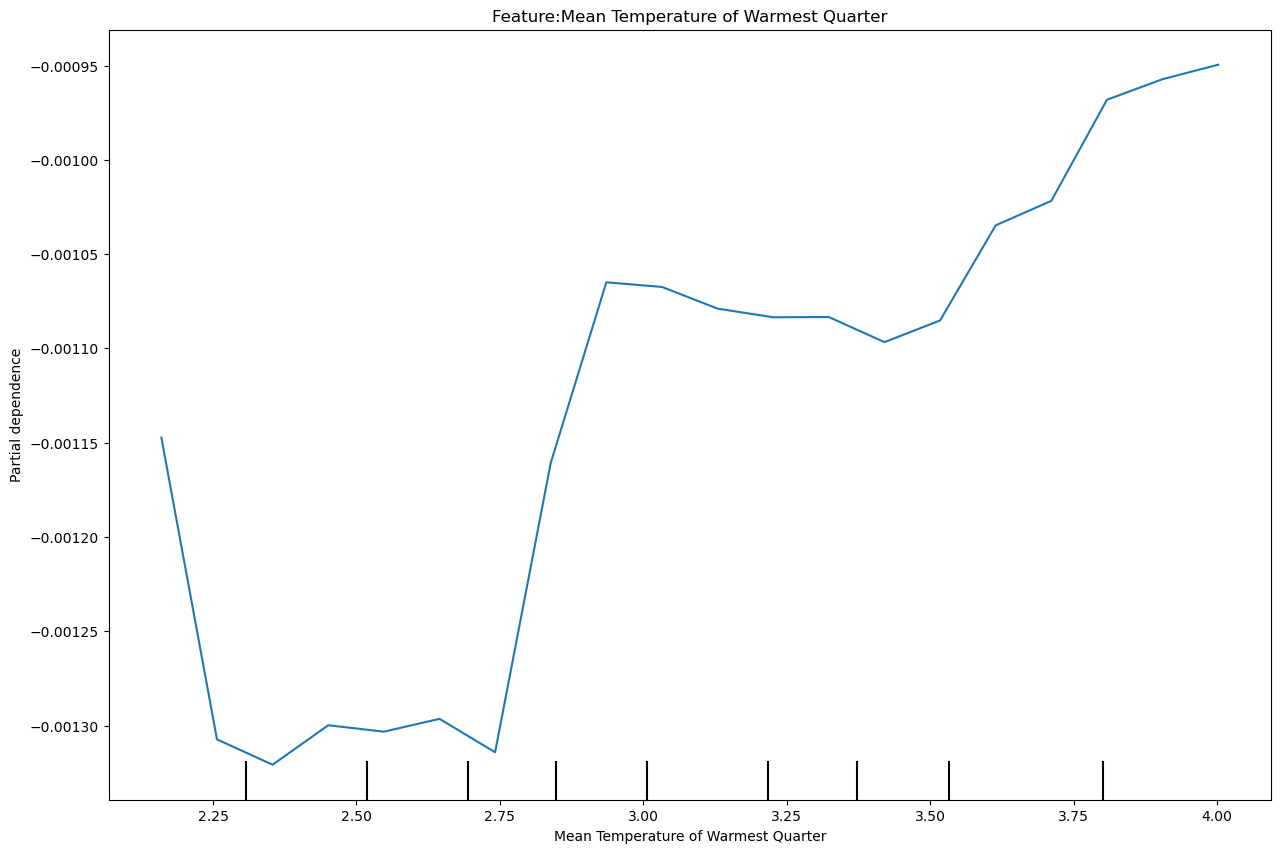

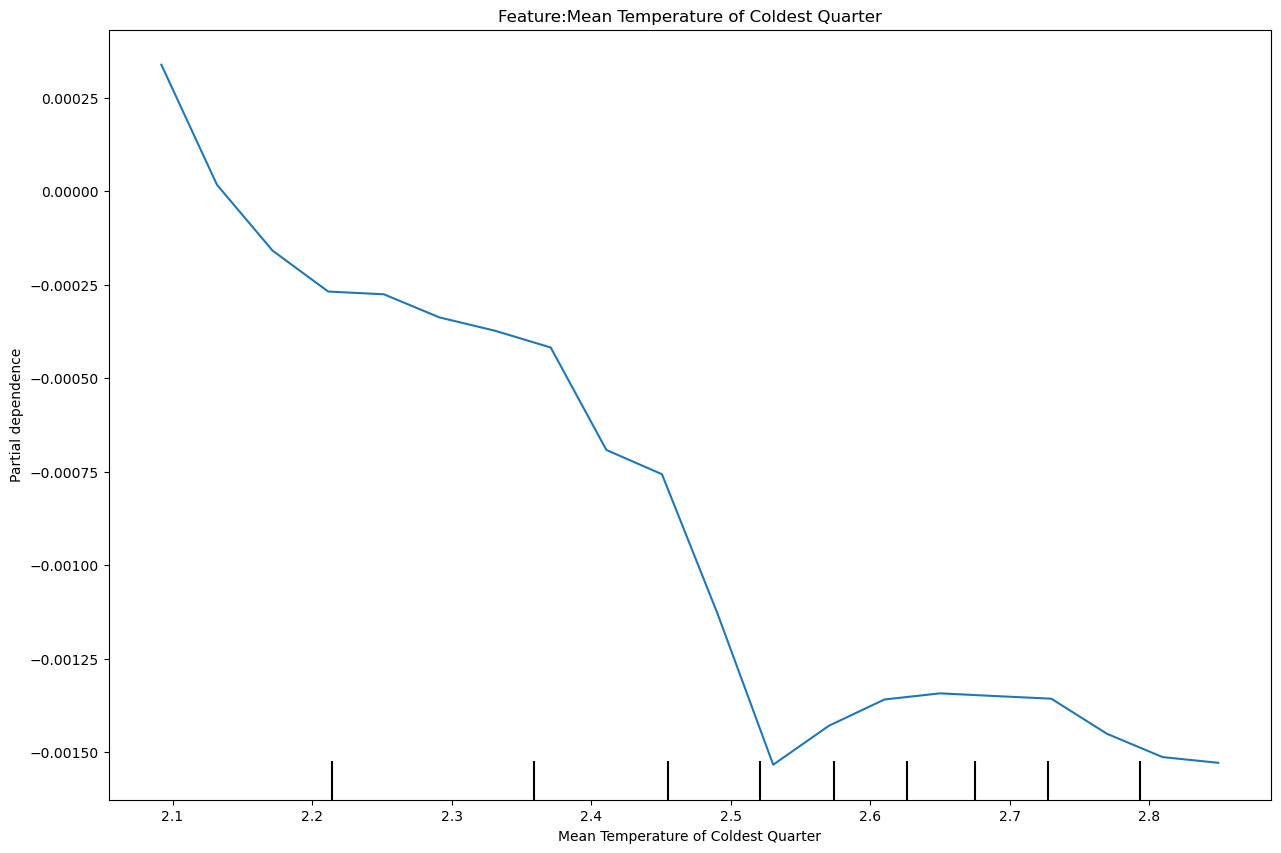

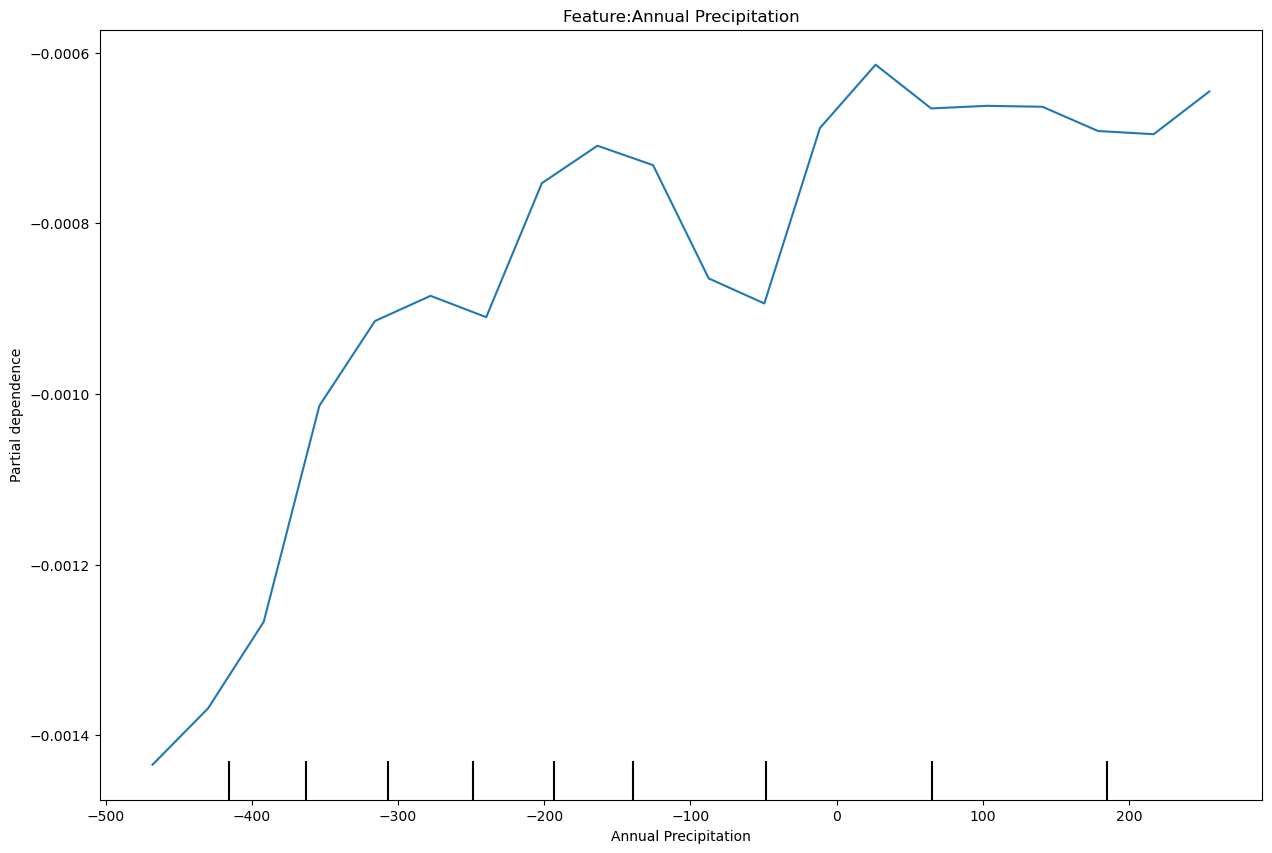

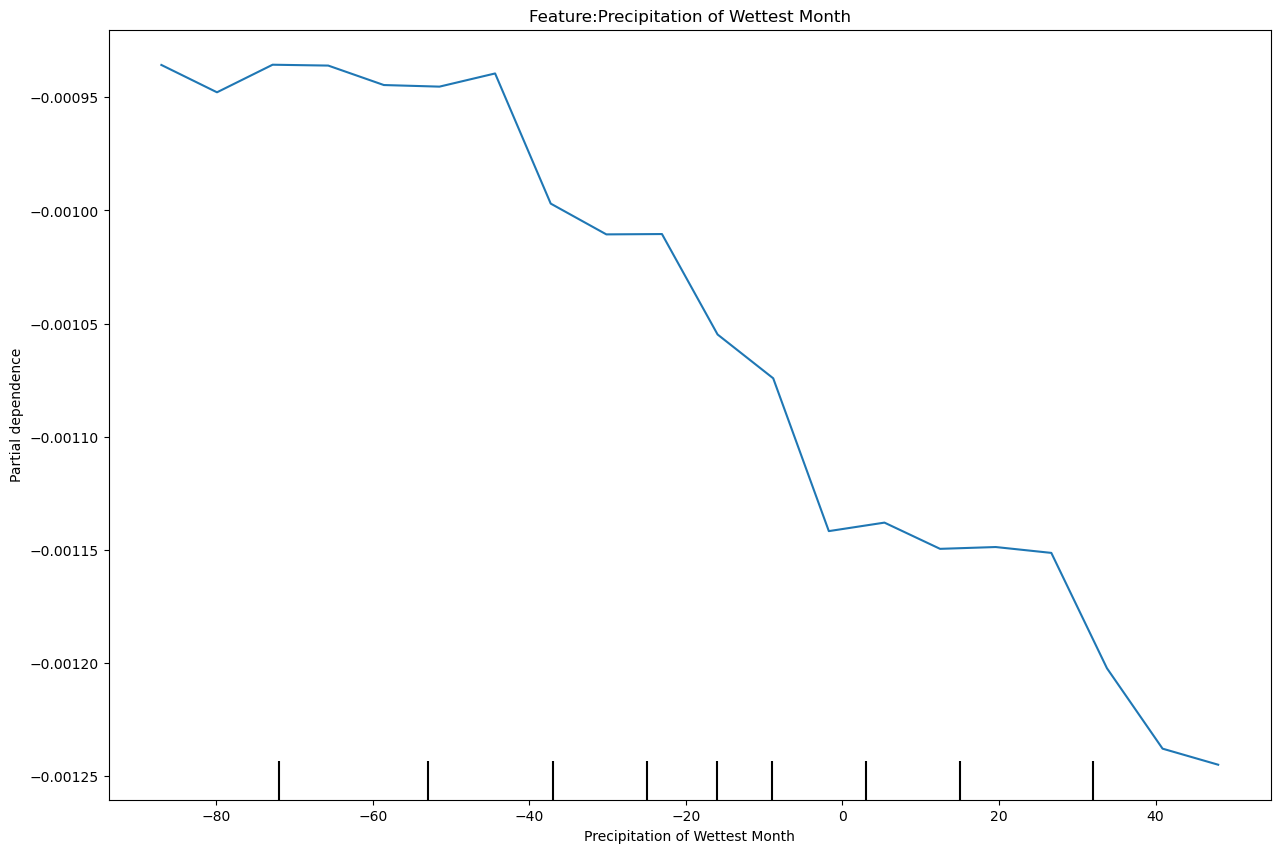

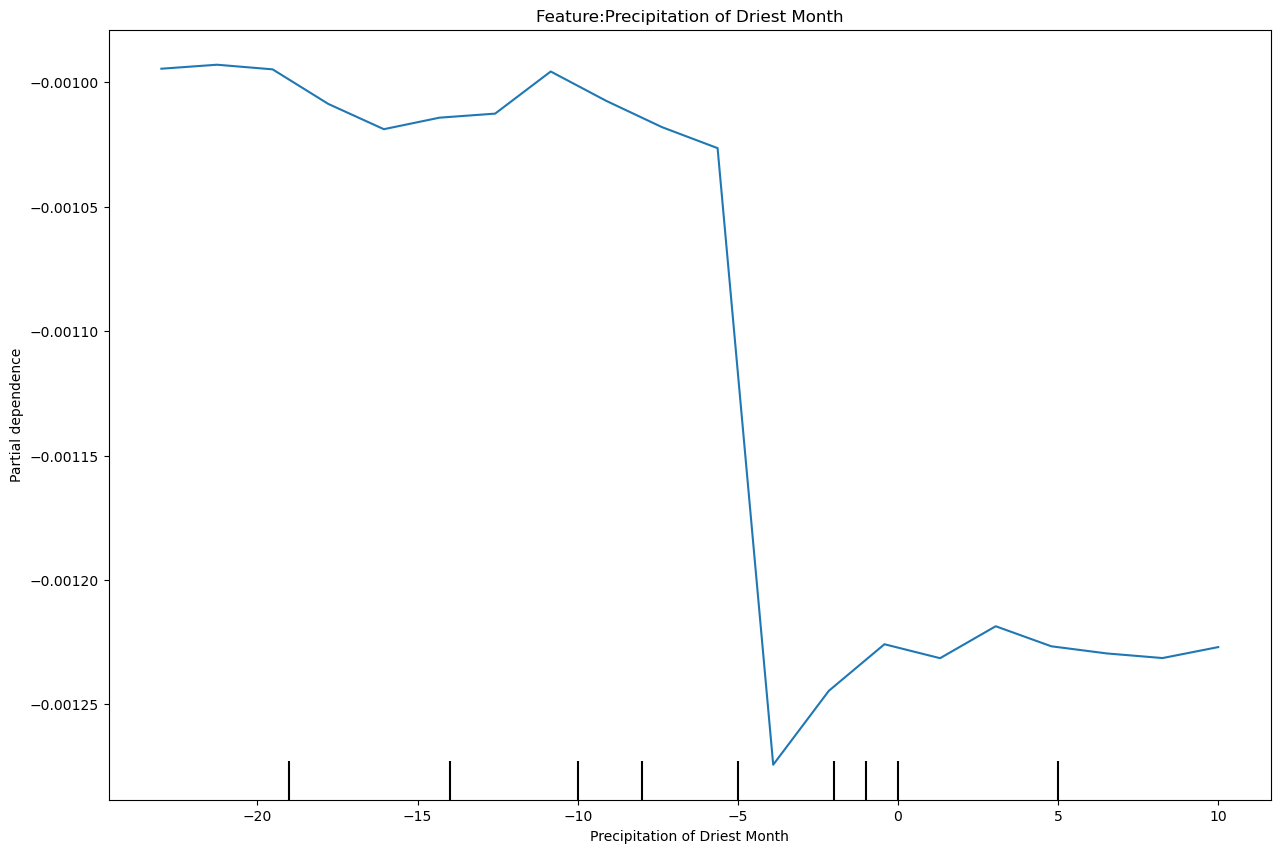

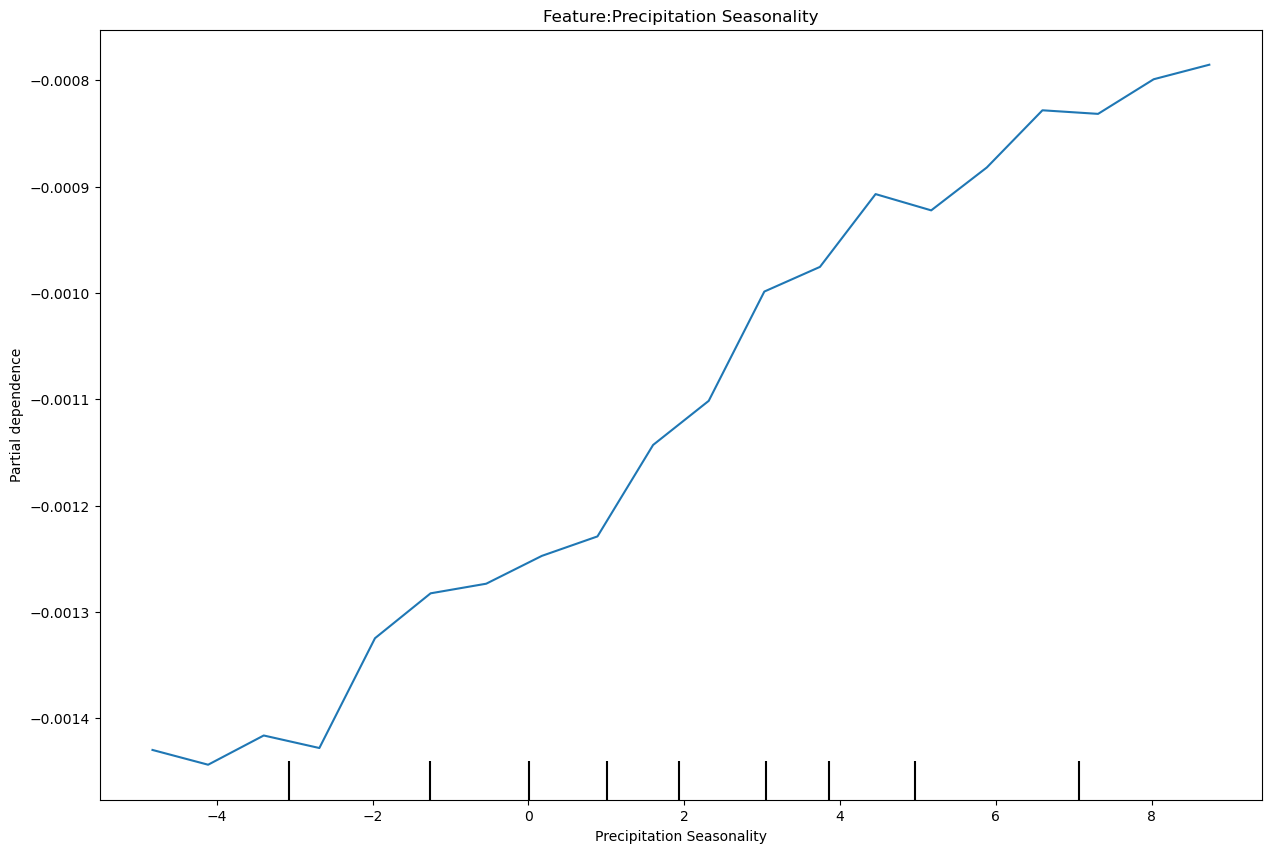

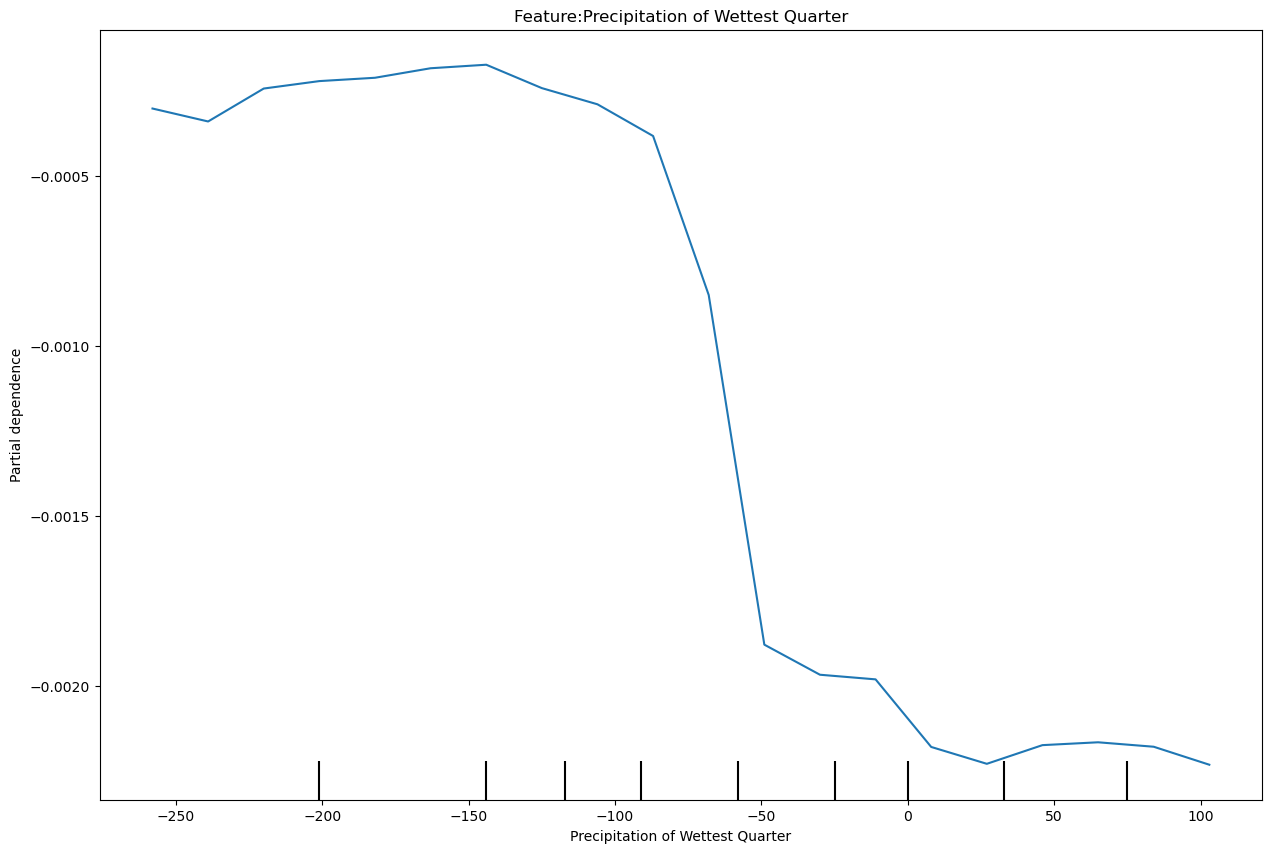

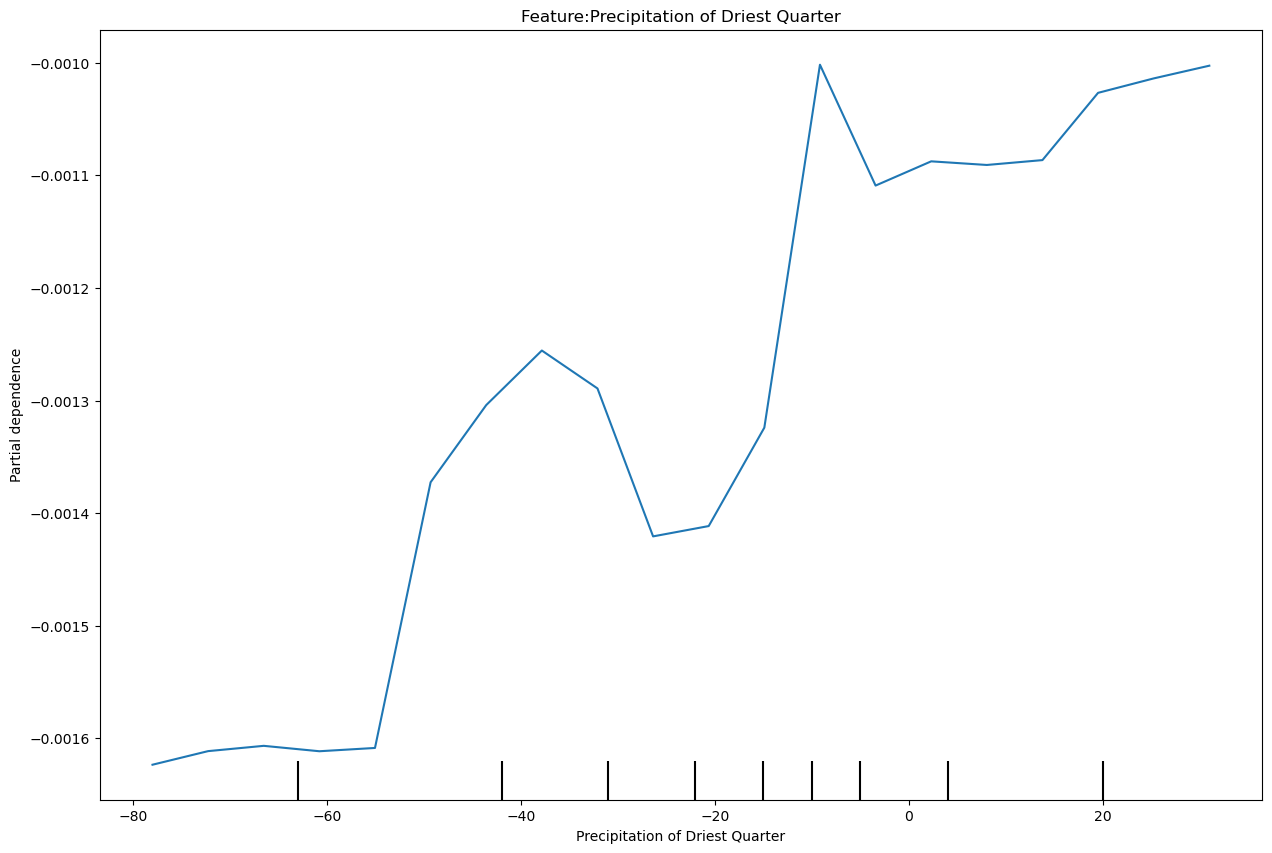

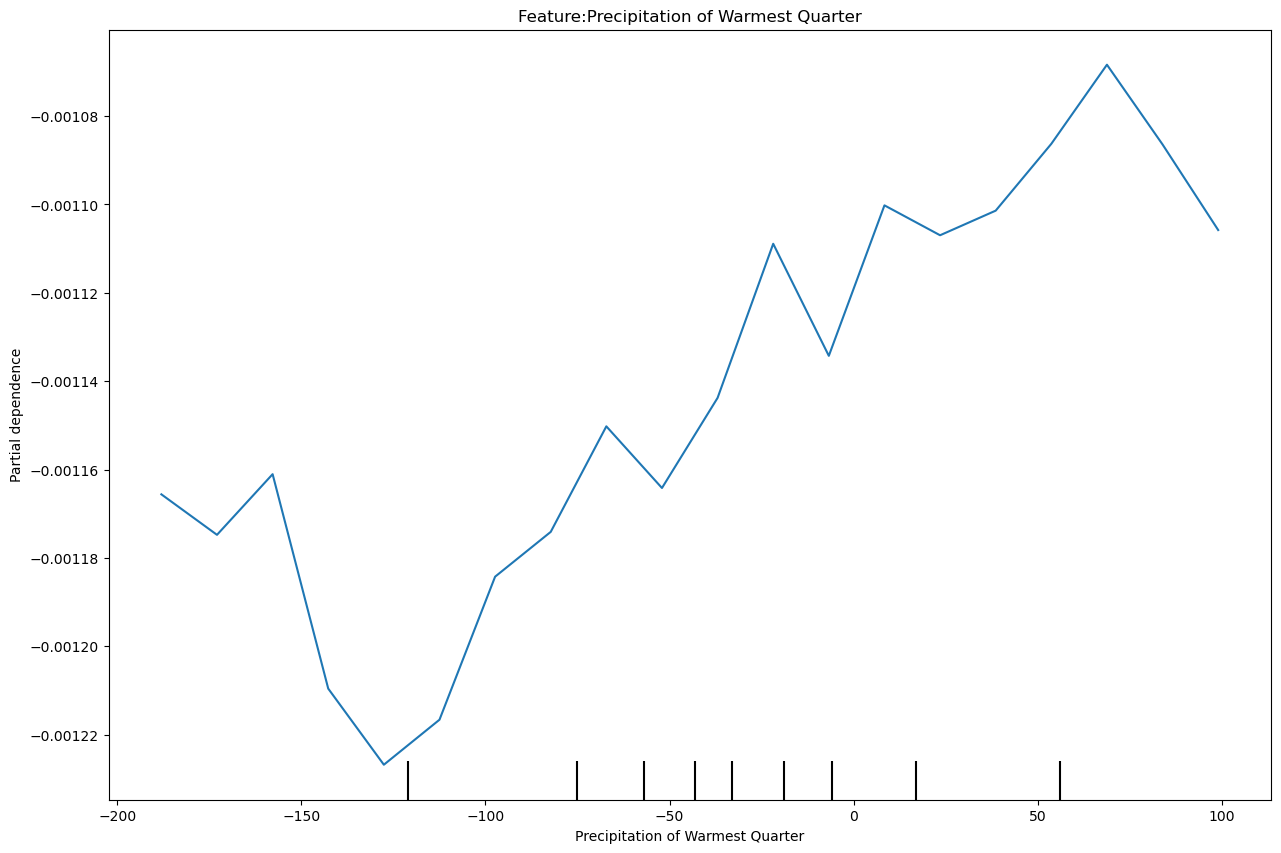

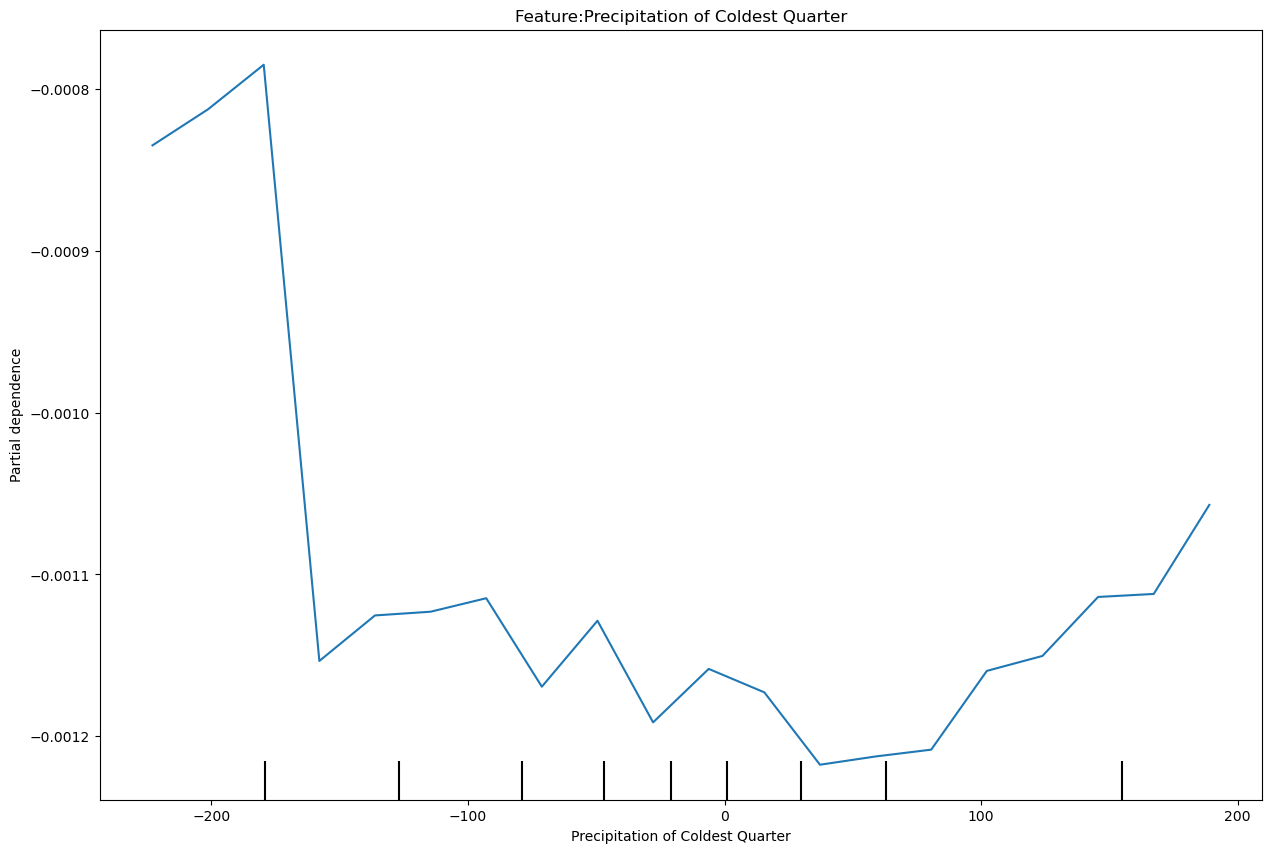

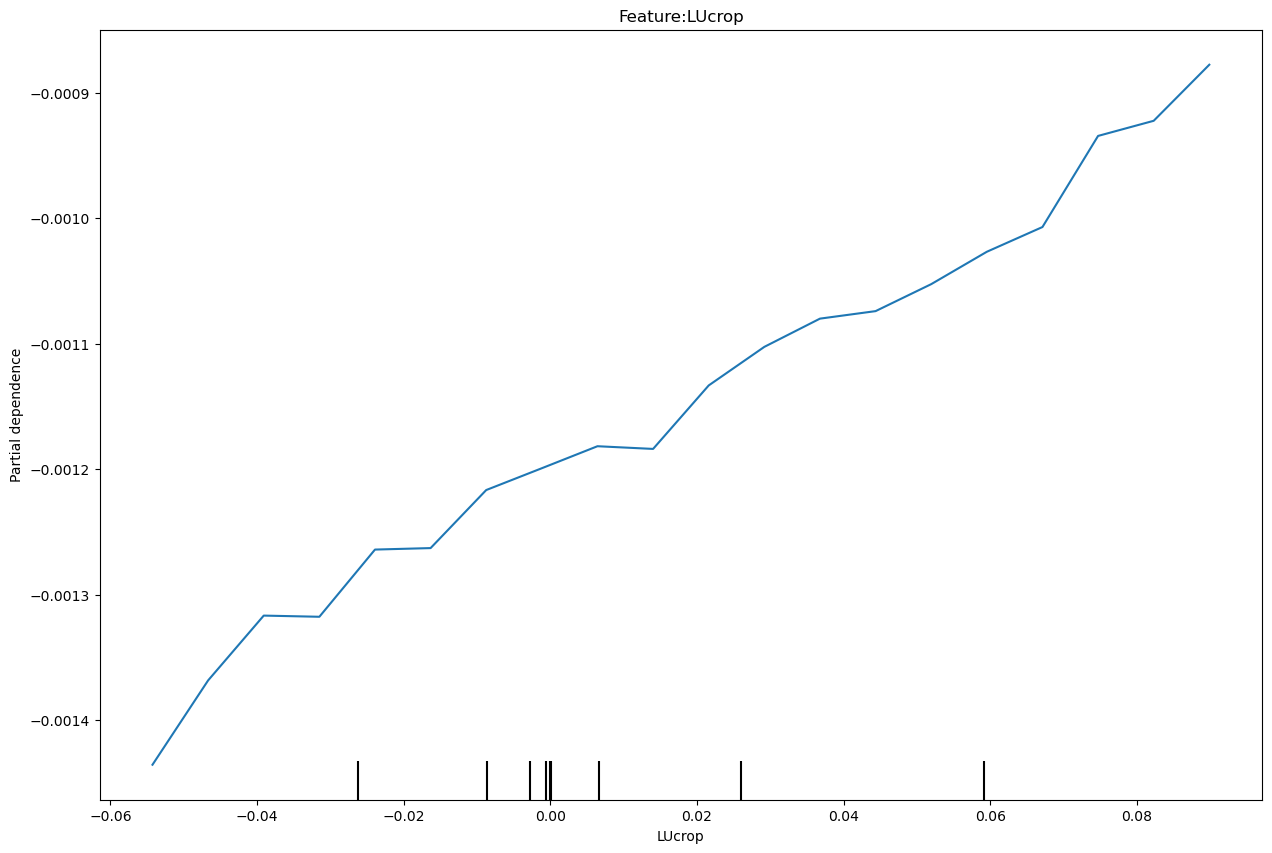

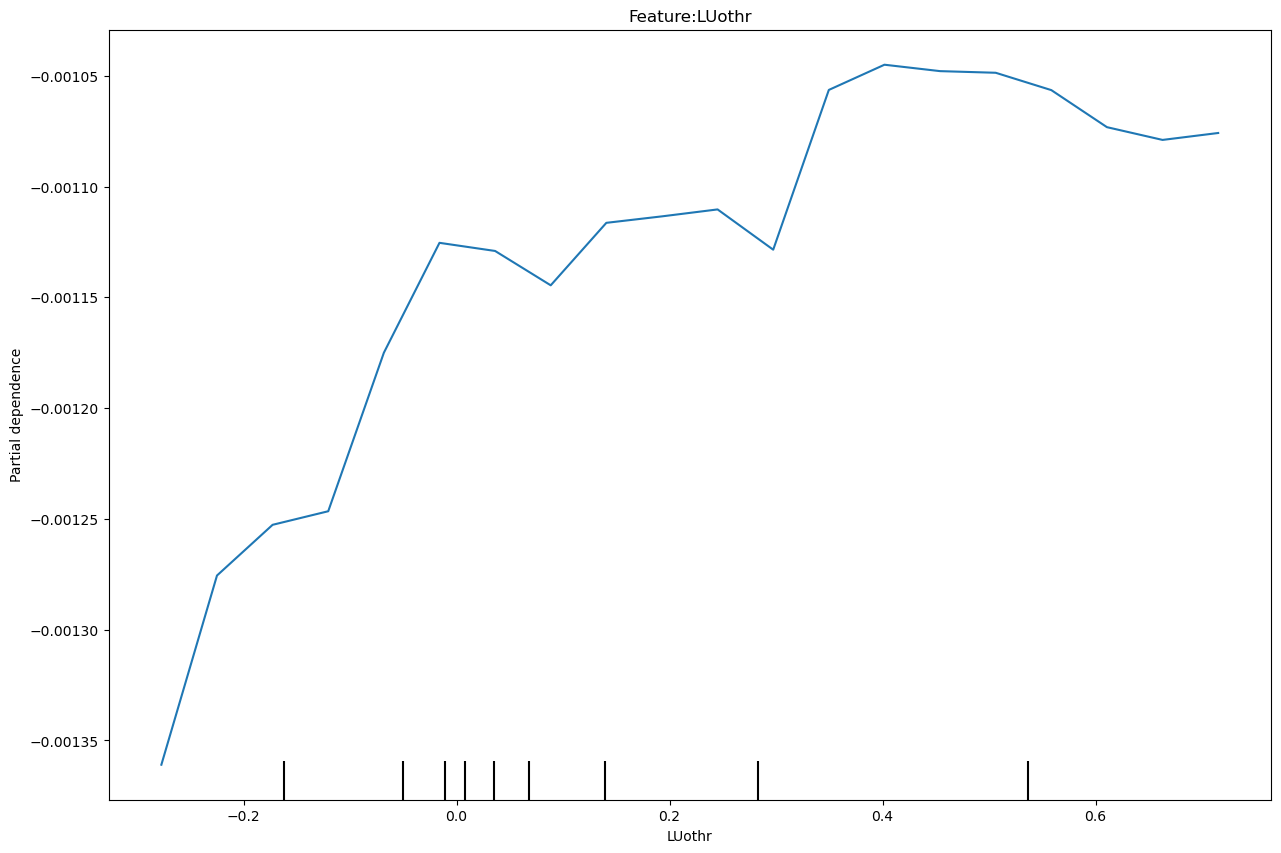

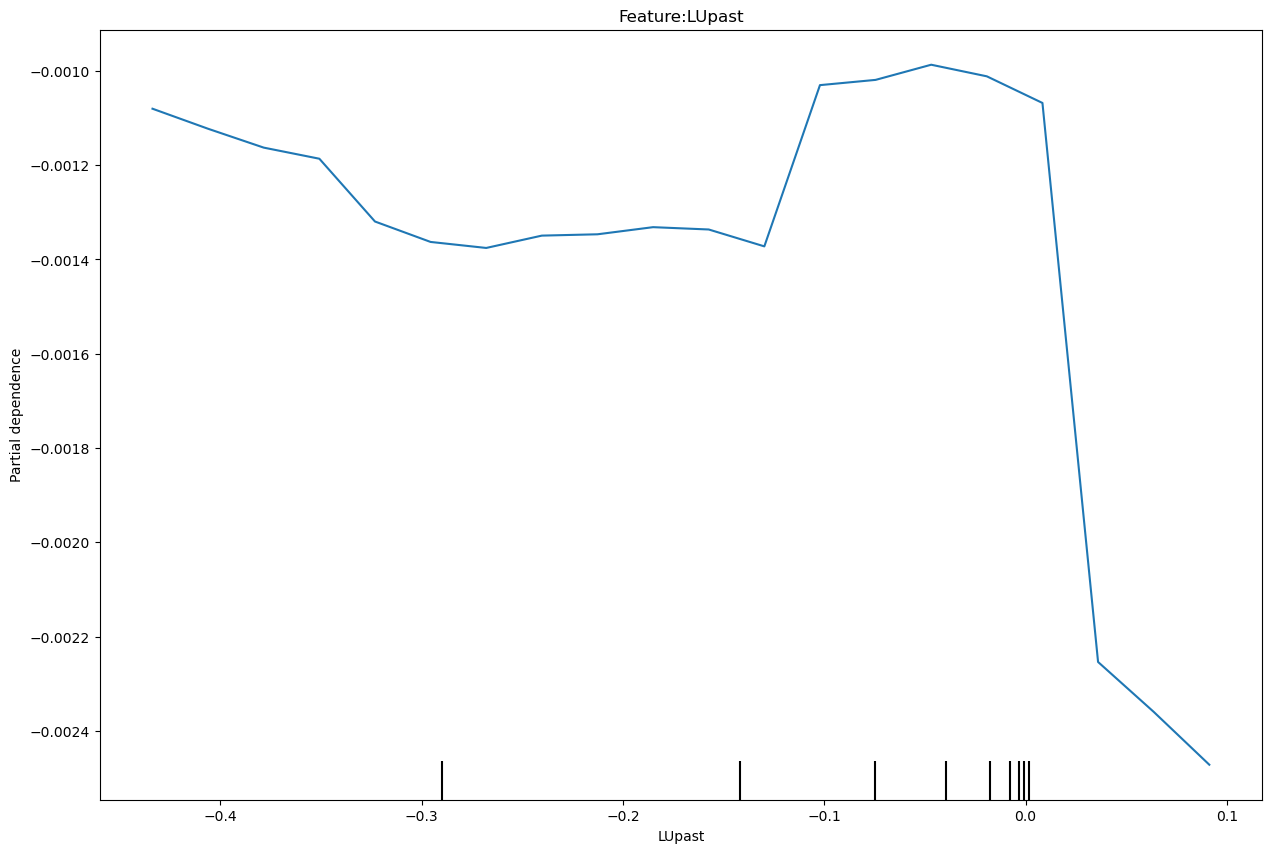

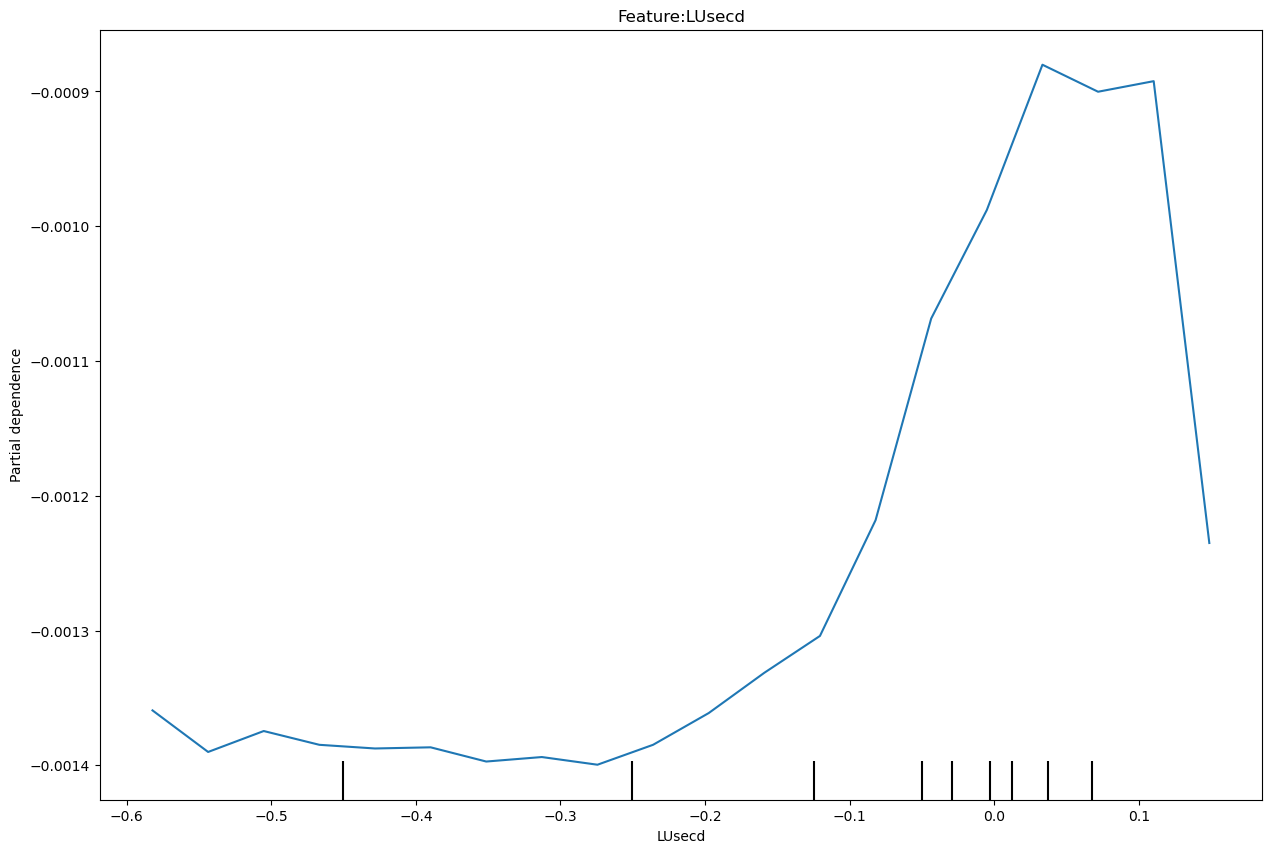

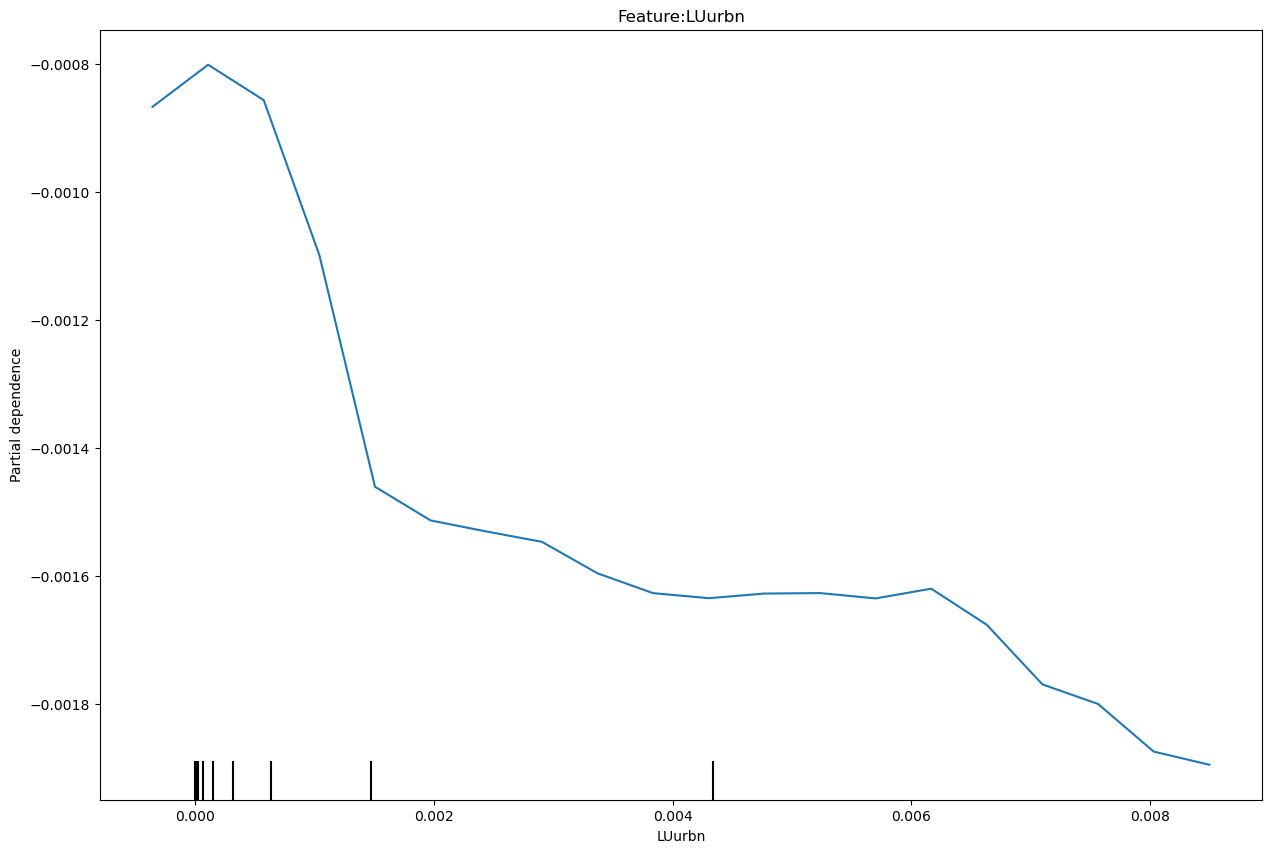

In [13]:
for i, feature in enumerate(list(range(X_train.shape[1]))):
    fig, ax = plt.subplots(figsize = (15,10))
    PartialDependenceDisplay.from_estimator(model_out2, X_train, 
                                        features = [feature], 
                                        feature_names = feature_names,
                                            ax = ax,
                                        grid_resolution = 20)
    ax.set_title(f'Feature:{feature_names[feature]}')
    
    plt.show(fig)

In [14]:
feat_imp = pd.DataFrame({'feats': feature_names, 'importances_ssp2': feat_imp, 'importances_ssp5': feat_imp2})
feat_imp

,feats,importances_ssp2,importances_ssp5
0,Annual Mean Temperature,0.047972,0.038862
1,Mean Diurnal Range,0.054597,0.052974
2,Isothermality,0.042914,0.038995
3,Temperature Seasonality,0.048583,0.119946
4,Max Temperature of Warmest Month,0.035240,0.034528
5,Min Temperature of Coldest Month,0.036730,0.038730
6,Temperature Annual Range,0.037098,0.032465
7,Mean Temperature of Wettest Quarter,0.049876,0.042348
8,Mean Temperature of Driest Quarter,0.046830,0.039024
9,Mean Temperature of Warmest Quarter,0.045673,0.036151


In [15]:
# pdp_results = partial_dependence(model_out2, X_train, features = indices)


# grid_values = pd.DataFrame()
# for i, feature in enumerate(indices):
#     feature_grid = pd.DataFrame({
#         f"Feature_{feature}_grid": pdp_results['grid_values'][i],  # Grid values
#         f"Feature_{feature}_pdp": pdp_results['average'][i]   # Partial dependence values
#     })
#     grid_values = pd.concat([grid_values, feature_grid], axis=1)

# grid_values.to_csv("./Data/Input/Processed/Projected/guan/delta_SSP5/delta_ssp5_FOI_ML_sig.csv", index = False)